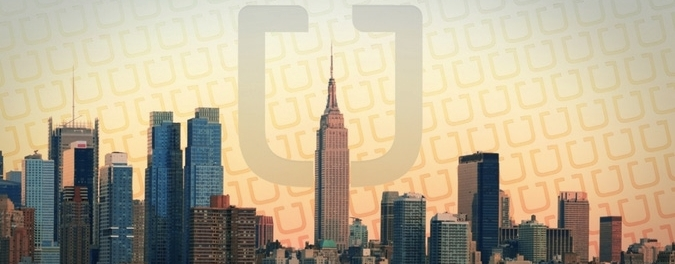

In [1]:
from IPython.display import Image

Image(filename='images/uber-new-york2.jpeg') 

# Forecasting Uber Demand in New York

## Table of Contents
1 [Project Overview](#1)  
    1.1 [Project Summary](#1.1)  
    1.2 [Assumption](#1.2)  
2 [Loading](#2)  
    2.1 [Import Libraries](#2.1)  
    2.2 [Functions](#2.2)  
    2.3 [Import Data](#2.3)  
3 [Exploring Data Analysis (EDA)](#3)  
    3.1 [Data Overview](#3.1)  
        3.1.1 [Input Variables](#3.1.1)  
        3.1.2 [Uber Trip Data](#3.1.2)  
        3.1.3 [Weather Data](#3.1.3)  
    3.2 [Data Preparation for Analysis](#3.2)  
    3.3 [Visualisation](#3.3)  
    3.4 [Summary of EDA](#3.4)  
4 [Preprocessing](#4)  
    4.1 [Fearture Engineering](#4.1)  
5 [Model Deployment](#5)  
    5.1 [Baseline Model](#5.1)  
    5.2 [Model Tuning](#5.2)  
        5.2.1 [Hyper-parameter Tuning](#5.2.1)  
        5.2.2 [Feature Selection](#5.2.2)
6 [Deploy](#6)  
    6.1 [Feature Importance](#6.1)  
    6.2 [Prediction vs True data](#6.2)

<a id="1"></a>
***
***
# Project Overview
***

<a id="1.1"></a>
***
***
## Project Summary 
***

### Situation
The demand for ride-sharing is drastically increasing, especially in large cities. Uber is the first ride-sharing company and has operations in over 900 metropolitan areas worldwide.  As rapidly growing demand and shortage of the vehicle, surge pricing for the rides is concerned these days. It is difficult to forecast the demand with various factors such as weather or public events. 

 
### Action and Goal
Time-series data for the Uber trip (January - June 2015) and the weather was used for exploratory data analysis, visualisation and forecasting model to test the hypothesis. All analysis was implemented on Python and Jupyter Notebook and a forecasting model was developed using a machine learning framework, called **XGBoost**. Using insights obtained from the analyses, this project aims to test the hypothesis **"Weather is a predictor of demand for Uber rides in New York"**.

### Results
The exploration and the build forecasting model shows that:  
- The demand follows specific daily and weekly patterns of hourly Uber rides.
- Weather variables did not have any or had very weak impacts on the forecasting model. i.e. the hypothesis was rejected. 

<a id="1.2"></a>
***
***
## Assumptions
***
- Since the available data is only for the first 6-month of the year 2015, the forecasting model may not accurately fit the true data.
- The seasonality of the data is ignored due to the limited time period of the data.
- Since all boroughs are neighbours, the weather information from a single source is used for all boroughs.
- The Forecasting is implemented for hourly demand for the rides because the weather data is hourly recorded.

<a id="2"></a>
***
***
# Loading 
***
This section loads required libraries, data as well as custom-made functions.

<a id="2.1"></a>
***
***
## Import Libraries
***
These libraries can be installed from **Pipfile** and **Pipfile.lock** using pipenv (**Python version: 3.8.10**)

In [2]:
# Import reqired libraries -----

import os, sys
sys.path.append(os.pardir)

import math
import warnings
warnings.filterwarnings('ignore')
from itertools import compress
from datetime import date, datetime
from functools import reduce

# EDA
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew

# Visualisation
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
plt.rcParams['font.size'] = '16'# Set general font size

# Modelling
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from boruta import BorutaPy
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)

<a id="2.2"></a>
***
***
## Functions 
***
Defined custom functions are shown in this section.

***
**Memory Usage**
***
Check the memory usage. If a variable not used occupy a large memory, it can be deleted. (var = dir() as input)

In [3]:
def memory_usage(var, lower_limit=0):
    ''' Memory Usage
    This code provides information about the memory usage
    
    Parameters
    ----------
    var = dir()
    lower_limit (default:0, optional): define the minimam value of the memory usage displayed
    
    Return
    ------
    print memory usage
    '''
    
    # input: var = dir()
    print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in var:
        if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > lower_limit:
            print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
    return

***
**Data Profile**
***
This function provides a summary of data structure in dataframe such as data types, count of the null data and count of the unique values. (See [Profile](#profile))

In [4]:
def data_profile(df):
    ''' Data Profile
    This code provides data profile for the inpiut dataframe
    
    Parameters
    ----------
    df (dataframe)
    
    Return
    ------
    df_profile (dataframe)
    '''
    # Datatype
    df_dtype = pd.DataFrame(df.dtypes)
    
    # Null count
    df_null = pd.DataFrame(df.isnull().sum())
    # Null ratio (%)
    null_ratio = df.isnull().sum() / df.shape[0] * 100 #Percentage
    null_ratio = null_ratio.apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    df_null_ratio = pd.DataFrame(null_ratio)
    
    # Non-null count
    df_notnull = pd.DataFrame(df.notnull().sum())
    
    # Unique value/Unique ratio(%)
    df_unique = {}
    df_unique_ratio = {}
    
    for column in df.columns:
        df_unique[column] = len(df[column].value_counts())
        df_unique_ratio[column] = len(df[column].value_counts()) / df.shape[0] *100 #Percentage
        
    df_unique = pd.DataFrame.from_dict(df_unique, orient='index')
    df_unique_ratio = pd.DataFrame.from_dict(df_unique_ratio, orient='index')
    df_unique_ratio = df_unique_ratio[0].apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    
    # Create a new dataframe showing the data profile 
    df_profile = pd.concat([df_dtype, df_null, df_null_ratio, df_notnull, df_unique, df_unique_ratio], axis=1).reset_index()
    df_profile.columns = ['Column', 'Data type', 'Null count', 'Null ratio (%)', 'Non-null count', 'Distinct', 'Distinct (%)']
    
    num_dup = df.duplicated().sum()
    if num_dup > 0:
        print(str(num_dup) + 'rows are duplicated')
    else: print('No duplicated row')
    return df_profile

***
***
## Import Data
<a id="2.3"></a>
***
All data used in this project is stored in "data" directory.  
  
**Uber trip data from 2015** (January - June)  
: with less fine-grained location information  
This data contains 14.3 million more Uber pickups from January to June 2015.
- uber-raw-data-janjune-15.csv
  
**Weather data**  
This dataset contains ~5 years of high temporal resolution (hourly measurements) data of various weather attributes shown as below:
- humidity.csv
- pressure.csv
- temperature.csv
- weather_description.csv
- wind_direction.csv
- wind_speed.csv
  
**(Data Source)**  
The data shown above can be obtained from:  
- Uber trip data: https://github.com/fivethirtyeight/uber-tlc-foil-response  
- Histroical weather in NY: https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=humidity.csv



In [5]:
# Uber data
uber_data_dir = 'data/uber-tlc-foil-response/uber-trip-data/uber-raw-data-'

# Raw data between January and June, 2015
uber_raw_janjun15 = pd.read_csv(uber_data_dir + 'janjune-15.csv', parse_dates=['Pickup_date'])
taxi_zone = pd.read_csv('data/uber-tlc-foil-response/uber-trip-data/taxi-zone-lookup.csv')

Base_code_ref = pd.DataFrame({
    'Base Code':['B02512', 'B02598', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02836'],
    'Base Name':['Unter', 'Hinter', 'Weiter', 'Schmecken', 'Danach-NY', 'Grun', 'Dreist', 'Drinnen']  
})

# Weather data
city_attrib = pd.read_csv('data/weather/city_attributes.csv')
humidity = pd.read_csv('data/weather/humidity.csv')
pressure = pd.read_csv('data/weather/pressure.csv')
temperature = pd.read_csv('data/weather/temperature.csv')
weather_description = pd.read_csv('data/weather/weather_description.csv')
wind_direction = pd.read_csv('data/weather/wind_direction.csv')
wind_speed = pd.read_csv('data/weather/wind_speed.csv')

In [6]:
# Check memory usage
# var = dir()
# memory_usage(var, lower_limit=1000)

<a id="3"></a>
***
***
# Exploring Data Analysis (EDA) 
***

<a id="3.1"></a>
***
***
## Data Overview
***
This section provides an overview of the Uber trip data and the weather data.

<a id="3.1.1"></a>
***
### Input Variables 
***
**Uber trip data (2015)**  
- Dispatching_base_num : The TLC base company code of the base that dispatched the Uber
- Pickup_date : The date and time of the Uber pickup
- Affiliated_base_num : The TLC base company code affiliated with the Uber pickup
- locationID : The pickup location ID affiliated with the Uber pickup

**Weather data**  
- datetime : The date and time of the weather record  
  
**taxi zone: reference of the borough**
- Location ID
- Borough
- Zone
***

<a id="3.1.2"></a>
***
### Uber rides data 
***

In [7]:
# Number of rows and columns
uber_raw_janjun15.shape

(14270479, 4)

In [8]:
# Uber trip data from 2015
uber_raw_janjun15.head()

Dispatching_base_num         Pickup_date Affiliated_base_num  locationID
0               B02617 2015-05-17 09:47:00              B02617         141
1               B02617 2015-05-17 09:47:00              B02617          65
2               B02617 2015-05-17 09:47:00              B02617         100
3               B02617 2015-05-17 09:47:00              B02774          80
4               B02617 2015-05-17 09:47:00              B02617          90

In [9]:
# Location reference
taxi_zone.head()

LocationID        Borough                     Zone
0           1            EWR           Newark Airport
1           2         Queens              Jamaica Bay
2           3          Bronx  Allerton/Pelham Gardens
3           4      Manhattan            Alphabet City
4           5  Staten Island            Arden Heights

#### Add borough information based on location ID

In [10]:
# Borough
uber_raw_janjun15['borough'] = uber_raw_janjun15['locationID']\
                            .map(taxi_zone.set_index('LocationID')['Borough'])
uber_raw_janjun15['borough'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island',
       'Unknown', 'EWR'], dtype=object)

In [11]:
uber_raw_janjun15.head()

Dispatching_base_num         Pickup_date Affiliated_base_num  locationID  \
0               B02617 2015-05-17 09:47:00              B02617         141   
1               B02617 2015-05-17 09:47:00              B02617          65   
2               B02617 2015-05-17 09:47:00              B02617         100   
3               B02617 2015-05-17 09:47:00              B02774          80   
4               B02617 2015-05-17 09:47:00              B02617          90   

     borough  
0  Manhattan  
1   Brooklyn  
2  Manhattan  
3   Brooklyn  
4  Manhattan

#### Format date and time

In [12]:
# convert string to timestamp object
uber_raw_janjun15['datetime'] = pd.to_datetime(uber_raw_janjun15['Pickup_date'])

In [13]:
# extract date and time (hour)
uber_raw_janjun15['datehour'] = uber_raw_janjun15['datetime'].dt.floor('1h')

#### Time period of the uber trip data

In [14]:
print('Uber trip data from 2015')
print('Min date: %s' % uber_raw_janjun15['datetime'].min())
print('Max date: %s' % uber_raw_janjun15['datetime'].max())

Uber trip data from 2015
Min date: 2015-01-01 00:00:05
Max date: 2015-06-30 23:59:00


#### Data Profile 

In [15]:
data_profile(uber_raw_janjun15)

898225rows are duplicated


Column       Data type  Null count  Null ratio (%)  \
0  Dispatching_base_num          object           0            0.00   
1           Pickup_date  datetime64[ns]           0            0.00   
2   Affiliated_base_num          object      162195            1.13   
3            locationID           int64           0            0.00   
4               borough          object           0            0.00   
5              datetime  datetime64[ns]           0            0.00   
6              datehour  datetime64[ns]           0            0.00   

   Non-null count  Distinct  Distinct (%)  
0        14270479         8          0.00  
1        14270479   2744783         19.23  
2        14108284       284          0.00  
3        14270479       262          0.00  
4        14270479         7          0.00  
5        14270479   2744783         19.23  
6        14270479      4334          0.03

<div class='alert-info'>

- The uber trip data for 2015 has a lot of duplicated rows. This just indicates there were rides at the same time in the same pick up area.  
- 1.1% of Affliated_base_num is NaN values.

</div>

<div class='alert-success'>

There is no problem with the raw data of the 2015 Uber rides at this stage. No further action is required.

</div>

<a id="3.1.3"></a>
***
### Weather data 
***

#### Extract and concatenate the weather data for New York 

In [16]:
# Extract weather in NY and merge weather data

# merged weather data
dataframes = [
    humidity[['datetime','New York']]
    , pressure[['datetime','New York']]
    , temperature[['datetime','New York']]
    , weather_description[['datetime','New York']]
    , wind_direction[['datetime','New York']]
    , wind_speed[['datetime','New York']]
]

# merged data frame for weather data in NY
weather_NY = reduce(lambda left, right: pd.merge(left, right , on='datetime',
                   how='outer'), dataframes)

weather_NY.columns = ['datetime', 'humidity', 'pressure', 'temperature', 'weather_description', 'wind_direction', 'wind_speed']

# delete the unnecessary variables
del humidity, pressure, temperature, weather_description, wind_direction, wind_speed

In [17]:
# Weather data (01/01/2015 - 31/06/2015)
weather_NY_15 = weather_NY.loc[(weather_NY['datetime'] < '2015-07')&(weather_NY['datetime'] > '2015')]

del weather_NY

In [18]:
# Check memory usage
var = dir()
memory_usage(var, lower_limit=1000)
del var

|            Variable Name|    Memory|
 ------------------------------------ 
|            Base_code_ref|      1156|
|                 BorutaPy|      1064|
|                    Image|      1472|
|           StandardScaler|      1064|
|             XGBRegressor|      1064|
|              city_attrib|      5549|
|                taxi_zone|     38683|
|        uber_raw_janjun15|3184339654|
|            weather_NY_15|    838954|


#### Weather descriptions

In [19]:
weather_state = weather_NY_15['weather_description'].unique()
print(weather_state)
print('\n The number of the weather states is', len(weather_state))

['sky is clear' 'few clouds' 'broken clouds' 'overcast clouds'
 'light rain' 'moderate rain' 'heavy intensity rain' 'light snow'
 'scattered clouds' 'snow' 'mist' 'haze' 'fog' 'very heavy rain'
 'light intensity drizzle' 'proximity thunderstorm'
 'thunderstorm with light rain' 'thunderstorm' 'drizzle']

 The number of the weather states is 19


#### Temperature 

In [20]:
#Convert temperature (K) into temperature (C: degree Celsius)
weather_NY_15['temperature'] = weather_NY_15['temperature'] - 273.15

#### Format date and time  

In [21]:
weather_NY_15['datetime'] = pd.to_datetime(weather_NY_15['datetime'])

In [22]:
# extract date and time (hour)
weather_NY_15['datehour'] = weather_NY_15['datetime'].dt.floor('1h')

In [23]:
print('Weather data (2015)')
print(weather_NY_15['datetime'].min())
print(weather_NY_15['datetime'].max())

Weather data (2015)
2015-01-01 00:00:00
2015-06-30 23:00:00


#### Basic summary of the weather data 

In [24]:
data_profile(weather_NY_15)

No duplicated row


Column       Data type  Null count  Null ratio (%)  \
0             datetime  datetime64[ns]           0             0.0   
1             humidity         float64           0             0.0   
2             pressure         float64           0             0.0   
3          temperature         float64           0             0.0   
4  weather_description          object           0             0.0   
5       wind_direction         float64           0             0.0   
6           wind_speed         float64           0             0.0   
7             datehour  datetime64[ns]           0             0.0   

   Non-null count  Distinct  Distinct (%)  
0            4344      4344        100.00  
1            4344        77          1.77  
2            4344        66          1.51  
3            4344      3081         70.92  
4            4344        19          0.43  
5            4344       354          8.14  
6            4344        11          0.25  
7            4344      4344        100.00

In [25]:
weather_NY_15.describe().T\
    .style.bar(subset=['mean'], color =px.colors.qualitative.G10[0])\
    .background_gradient(subset=['std'], cmap='Greens')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

<div class='alert-success'>

The weather data for the first 6 months in 2015 does not have missing data and duplicated data 

</div>

<a id="3.2"></a>
***
***
## Data Preparation for Analysis
***
This section provides the required variables and dataframe for further analysis in the later section. The created data is shown below:  
- df_hourly_rides:  
contains the number of rides per hour and the weather information for each timestamp.
- df_hourly_rides_borough:  
contains the number of rides per hour by borough and the weather information for each timestamp.

### Hourly demand for rides

In [26]:
# hourly rides from all borough
# hourly_Uber_rides = uber_raw_janjun15.Pickup_date.value_counts().resample('H').sum().reset_index()
# hourly_Uber_rides.columns  = ['datetime', 'count']
# hourly_Uber_rides.head()

In [27]:
# hourly rides from all borough
hourly_total_rides = uber_raw_janjun15[['datehour','datetime']]\
                    .groupby('datehour')\
                    .count()\
                    .reset_index()
hourly_total_rides.columns  = ['datehour', 'count']

In [28]:
hourly_total_rides.head()

datehour  count
0 2015-01-01 00:00:00   6465
1 2015-01-01 01:00:00   6001
2 2015-01-01 02:00:00   7171
3 2015-01-01 03:00:00   5874
4 2015-01-01 04:00:00   3529

### Hourly demand for rides by borough

In [29]:
# hourly rides from all borough
hourly_rides_borough = uber_raw_janjun15[['datehour','datetime','borough']]\
                        .groupby(['datehour','borough'])\
                        .count()\
                        .reset_index()
hourly_rides_borough.columns  = ['datehour','borough', 'count']

In [30]:
hourly_rides_borough.head()

datehour        borough  count
0 2015-01-01          Bronx    144
1 2015-01-01       Brooklyn   1371
2 2015-01-01      Manhattan   4567
3 2015-01-01         Queens    377
4 2015-01-01  Staten Island      3

### Merge Uber rides data and weather data

In [31]:
df_hourly_rides = pd.merge(hourly_total_rides, weather_NY_15, on='datehour')
df_hourly_rides_borough = pd.merge(hourly_rides_borough, weather_NY_15, on='datehour')

In [32]:
# add day of week(0:Sun, 1:Mon,...,6)
df_hourly_rides['day_of_week'] = df_hourly_rides['datetime'].dt.strftime('%w')
df_hourly_rides_borough['day_of_week'] = df_hourly_rides_borough['datetime'].dt.strftime('%w')

In [33]:
df_hourly_rides.head()

datehour  count            datetime  humidity  pressure  \
0 2015-01-01 00:00:00   6465 2015-01-01 00:00:00      59.0    1022.0   
1 2015-01-01 01:00:00   6001 2015-01-01 01:00:00      59.0    1022.0   
2 2015-01-01 02:00:00   7171 2015-01-01 02:00:00      58.0    1021.0   
3 2015-01-01 03:00:00   5874 2015-01-01 03:00:00      58.0    1021.0   
4 2015-01-01 04:00:00   3529 2015-01-01 04:00:00      58.0    1021.0   

   temperature weather_description  wind_direction  wind_speed day_of_week  
0       -5.100        sky is clear           249.0         2.0           4  
1       -5.100        sky is clear           249.0         2.0           4  
2       -5.964        sky is clear           246.0         2.0           4  
3       -5.964        sky is clear           246.0         2.0           4  
4       -5.964        sky is clear           246.0         2.0           4

<a id="3.3"></a>
***
***
## Visualization 
***
In this section, some key plots are shown.

### The Number of Rides by Borough 

In [34]:
# The number of rides by borough
total_rides_by_borough = df_hourly_rides_borough.groupby('borough')['count'].agg(sum).reset_index()
total_rides_by_borough.columns = ['borough','count']
total_rides_by_borough

borough     count
0          Bronx    220146
1       Brooklyn   2322000
2            EWR       105
3      Manhattan  10371060
4         Queens   1343945
5  Staten Island      6959
6        Unknown      6264

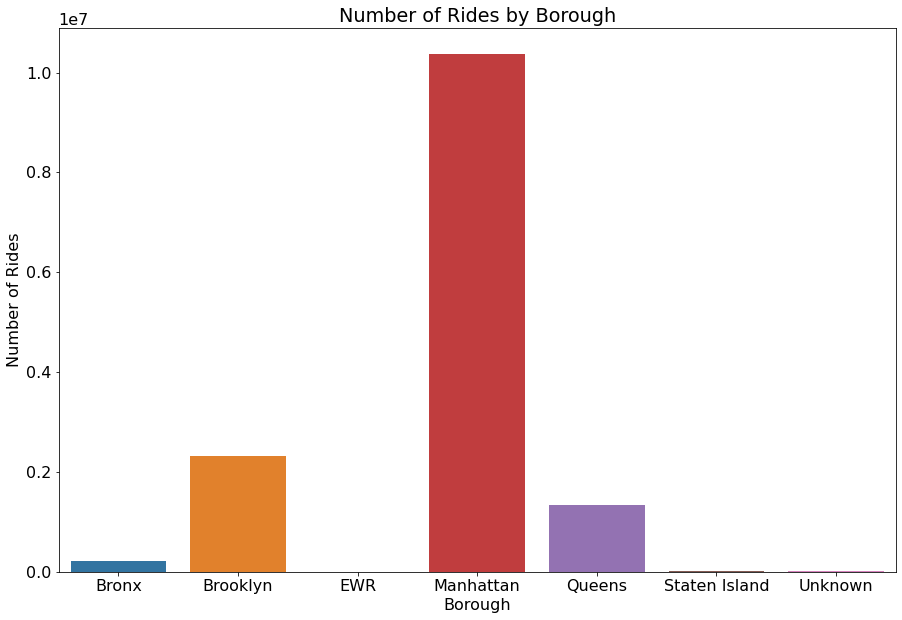

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='borough', y = 'count', data = total_rides_by_borough)
ax.set_title('Number of Rides by Borough');
ax.set_xlabel('Borough', fontsize=16);
ax.set_ylabel('Number of Rides', fontsize=16);

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
    
plt.savefig('images/rides_borough_barchart.png')

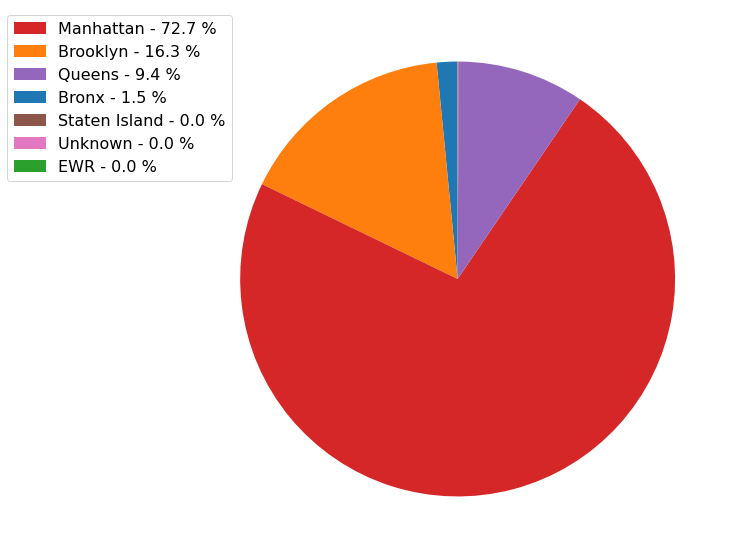

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
borough = total_rides_by_borough['borough'].unique()
size = total_rides_by_borough['count']
#create pie chart
patches, texts = plt.pie(size, startangle=90, shadow=False)

# Legend setting
percent = 100.*size/size.sum()
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(borough, percent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, size),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(0.1, 1.), fontsize=16)

# Savefig
plt.savefig('images/rides_borough_piechart.png', bbox_inches='tight')

plt.show()

<div class='alert-info'>

Manhattan has the most populous county followed by Brooklyn and Queens.  

</div>

### Average Number of Rides by Weather Event

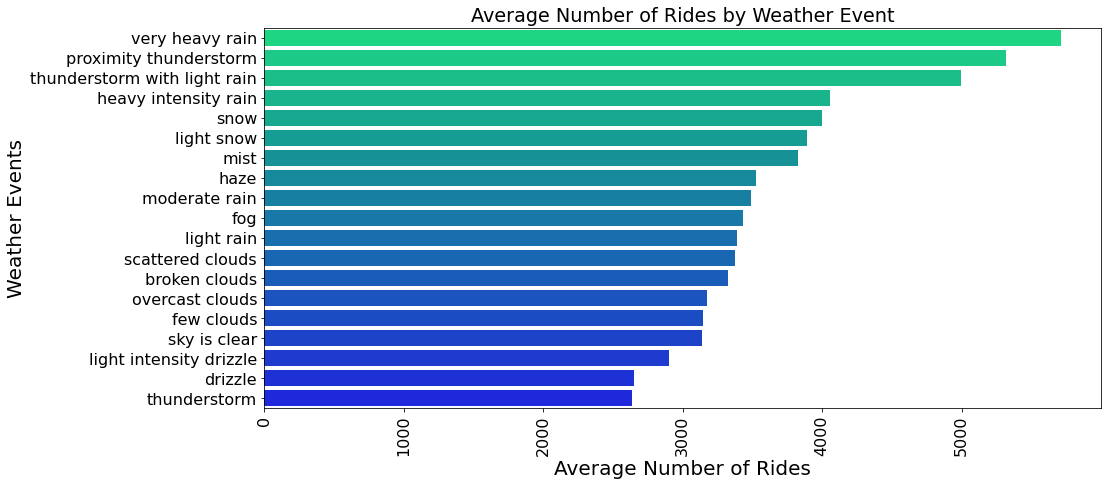

In [37]:
avg_rides_weather = df_hourly_rides.groupby('weather_description')['count'].mean().reset_index()
avg_rides_weather.columns = ['weather_description', 'avg_rides']
avg_rides_weather=avg_rides_weather.sort_values(by='avg_rides')

fig, ax = plt.subplots(figsize=(15,7))
# sns.barplot(x='weather_description', y = 'avg_rides', data = avg_rides_weather)
sns.barplot(y='weather_description', x='avg_rides', data = avg_rides_weather, palette='winter')
plt.xticks(rotation=90);
ax.set_title('Average Number of Rides by Weather Event')
ax.set_ylabel('Weather Events', fontsize=20)
ax.set_xlabel('Average Number of Rides', fontsize=20)
ax.invert_yaxis()
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

# Savefig
figname = 'Avg_rides_by_weather'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

<div class='alert-info'>

'Proximity thunderstorm', 'thunderstorm with light rain' and 'very heavy rain' have more rides. However, these weather events were probably not often occurred. So need to be careful to investigate the correlation.

</div>

### Average Number of Rides by Event and Borough

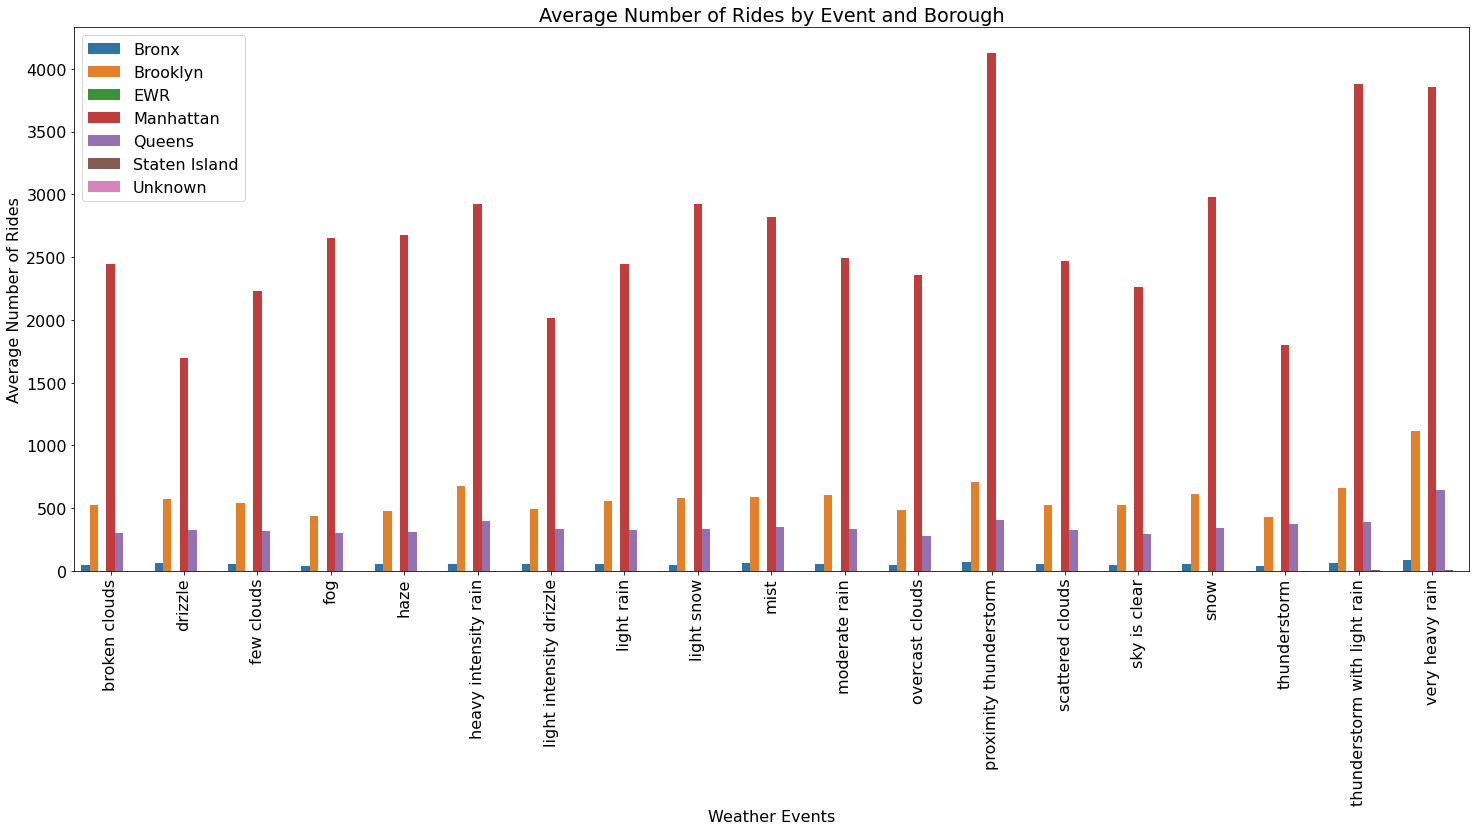

In [38]:
avg_rides_weather_borough = df_hourly_rides_borough.groupby(['weather_description','borough'])['count'].mean().reset_index()
avg_rides_weather_borough.columns = ['weather_description', 'borough', 'avg_rides']

fig, ax = plt.subplots(figsize=(25,10))
sns.barplot(x='weather_description', y = 'avg_rides', hue = 'borough', data = avg_rides_weather_borough)
plt.xticks(rotation=90);
ax.set_title('Average Number of Rides by Event and Borough');
ax.set_xlabel('Weather Events', fontsize=16);
ax.set_ylabel('Average Number of Rides', fontsize=16);
plt.legend(loc='upper left')

figname = 'Avg_rides_by_weather_borough'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

### Number of Rides per hour by Month

In [39]:
df_hour = df_hourly_rides[['datetime','datehour','day_of_week','count']]
hourly_rides_by_month = df_hour.copy()
hourly_rides_by_month['month'] = hourly_rides_by_month['datetime'].dt.month
hourly_rides_by_month['dayhour'] = hourly_rides_by_month['datetime'].dt.strftime('%d %H')
hourly_rides_by_month = hourly_rides_by_month.pivot('dayhour','month','count')

In [40]:
hourly_rides_by_month

month         1       2       3       4       5       6
dayhour                                                
01 00    6465.0  5940.0  5211.0  1863.0  2986.0  1885.0
01 01    6001.0  4469.0  4645.0  1087.0  1895.0  1488.0
01 02    7171.0  3279.0  3245.0   632.0  1166.0  1001.0
01 03    5874.0  2067.0  2084.0   430.0   752.0   638.0
01 04    3529.0  1222.0  1404.0   592.0  1058.0  1026.0
...         ...     ...     ...     ...     ...     ...
31 19    7245.0     NaN  6709.0     NaN  6541.0     NaN
31 20    6838.0     NaN  6975.0     NaN  5713.0     NaN
31 21    6574.0     NaN  5946.0     NaN  5029.0     NaN
31 22    6897.0     NaN  5029.0     NaN  4219.0     NaN
31 23    6870.0     NaN  3609.0     NaN  3670.0     NaN

[744 rows x 6 columns]

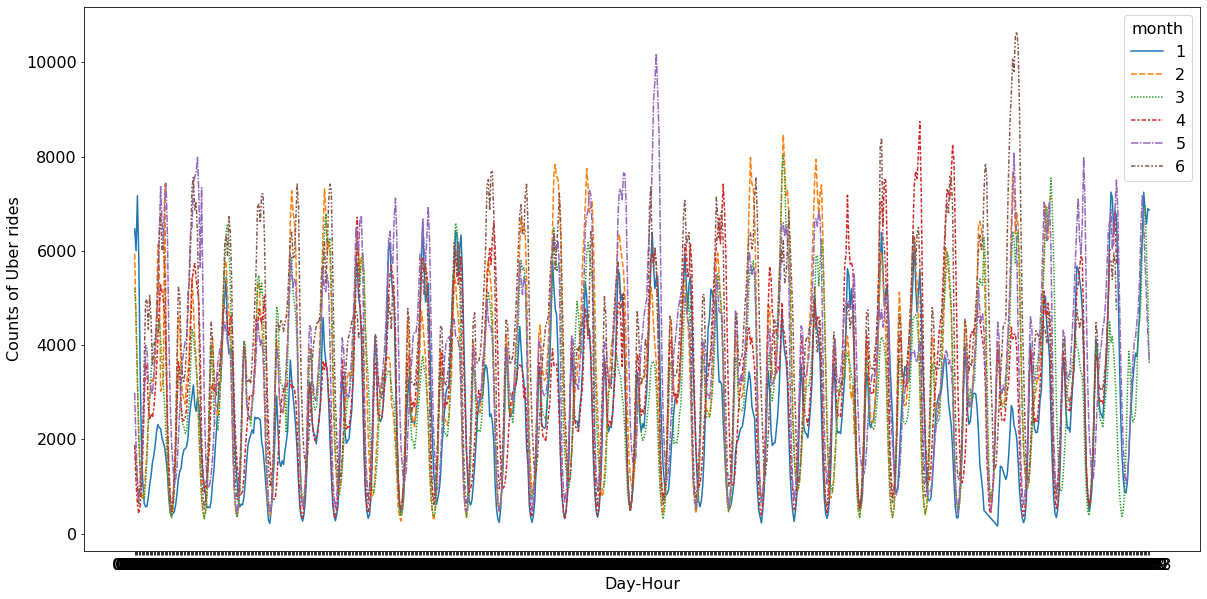

In [41]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=hourly_rides_by_month)
ax.set_ylabel('Counts of Uber rides');
ax.set_xlabel('Day-Hour');
# hours = mdates.HourLocator(interval = 10000)
# ax.xaxis.set_major_locator(hours)

### Average Number of the Rides by Month 

In [42]:
monthly_rides = df_hourly_rides.copy()
monthly_rides['month'] = df_hourly_rides['datetime'].dt.month
monthly_rides = monthly_rides[['count','month']].groupby(['month']).agg(sum).reset_index()
monthly_rides

month    count
0      1  1953801
1      2  2263620
2      3  2259773
3      4  2280837
4      5  2695553
5      6  2816895

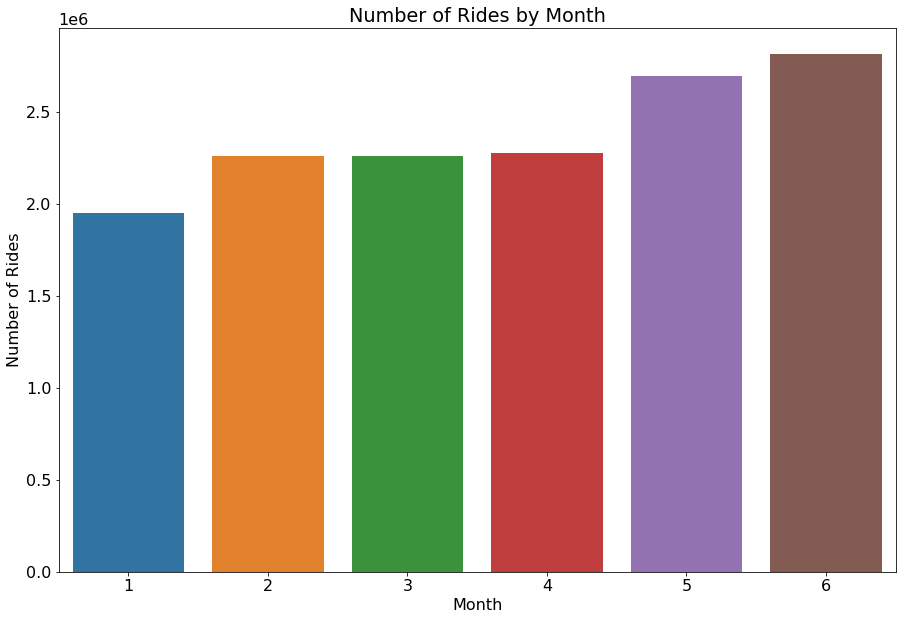

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='month', y = 'count', data = monthly_rides)
ax.set_title('Number of Rides by Month');
ax.set_xlabel('Month', fontsize=16);
ax.set_ylabel('Number of Rides', fontsize=16);

figname = 'N_rides_per_month'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

<div class='alert-info'>

- January has the lowest number of rides.
- June has the highest number of rides.

</div>

### Histogram of Number of Rides per hour

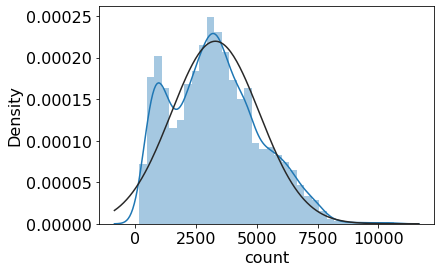

In [44]:
sns.distplot(df_hourly_rides['count'], fit=norm);

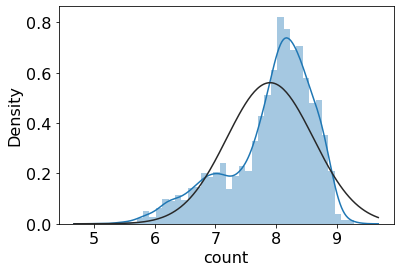

In [45]:
# Log of the rides counts
sns.distplot(np.log1p(df_hourly_rides['count']), fit=norm);

<div class='alert-danger'>

Distribution of the hourly rides is skewed.

</div>

### Histogram of the Uber Rides by the Weather Events 

In [46]:
# df_hourly_rides.hist(column="count", by='weather_description'
#         , sharex=True, sharey=False
#         , figsize=(20,15), layout=(4,5)
#         , color='b'
#        )

# plt.show()

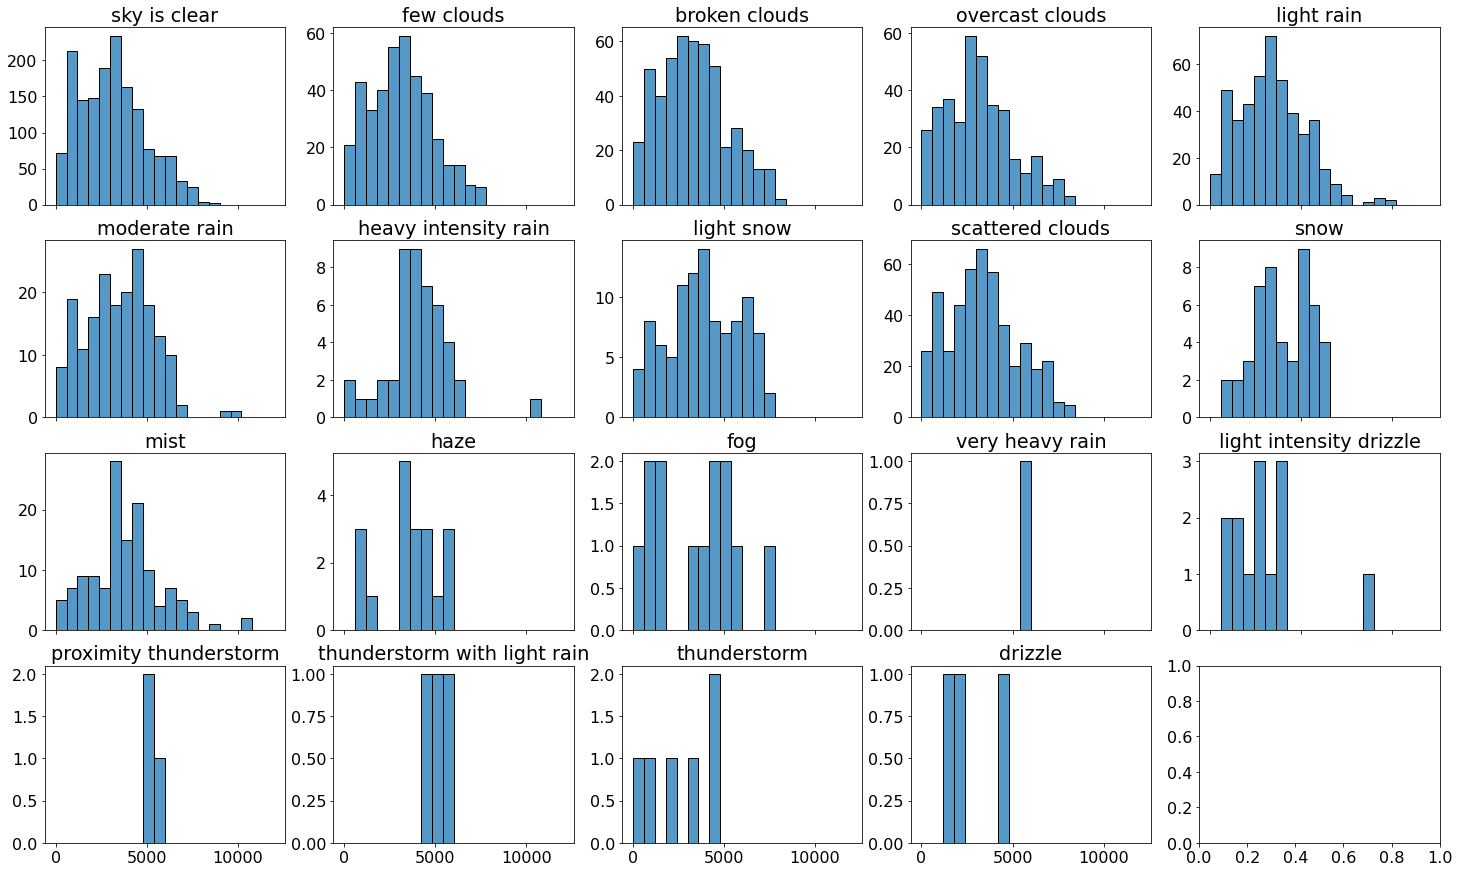

In [47]:
fig, axes = plt.subplots(4, 5, figsize=(25, 15))
weather_list = df_hourly_rides['weather_description'].unique()
for weather, ax in zip(weather_list, axes.flat):
    df_hourly_rides_weather = df_hourly_rides[df_hourly_rides['weather_description']==weather]
    sns.histplot(data=df_hourly_rides_weather, x='count', ax=ax
                ,bins=20, common_bins=True, binrange=[0,12000], color='#1f77b4')
  
    ax.set_ylabel('');
    ax.set_xlabel('');
    ax.set_title(weather);
for i in range(0,15):
    axes.flat[i].set_xticklabels([])

figname = 'N_rides_vs_WeatherEvents_hist'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

In [48]:
EventCount_by_weather = df_hourly_rides.groupby('weather_description').count()['count'].reset_index()
EventCount_by_weather.columns = ['Weather Event', 'Number of Occurence']
EventCount_by_weather.to_csv('results/WeatherEventOccurenceCount.csv', index=False)

<div class = 'alert-danger'>

- Some weather conditions (drizzle, fog, haze, heavy intensity rain, light intensity drizzle, proximity thunderstorm, snow, thunderstorm, thunderstorm with light rain, very heavy rain) are not frequent events (< 50 events)  
- The histogram is right-skewed

</div>

### Avrerage Demand through the Week

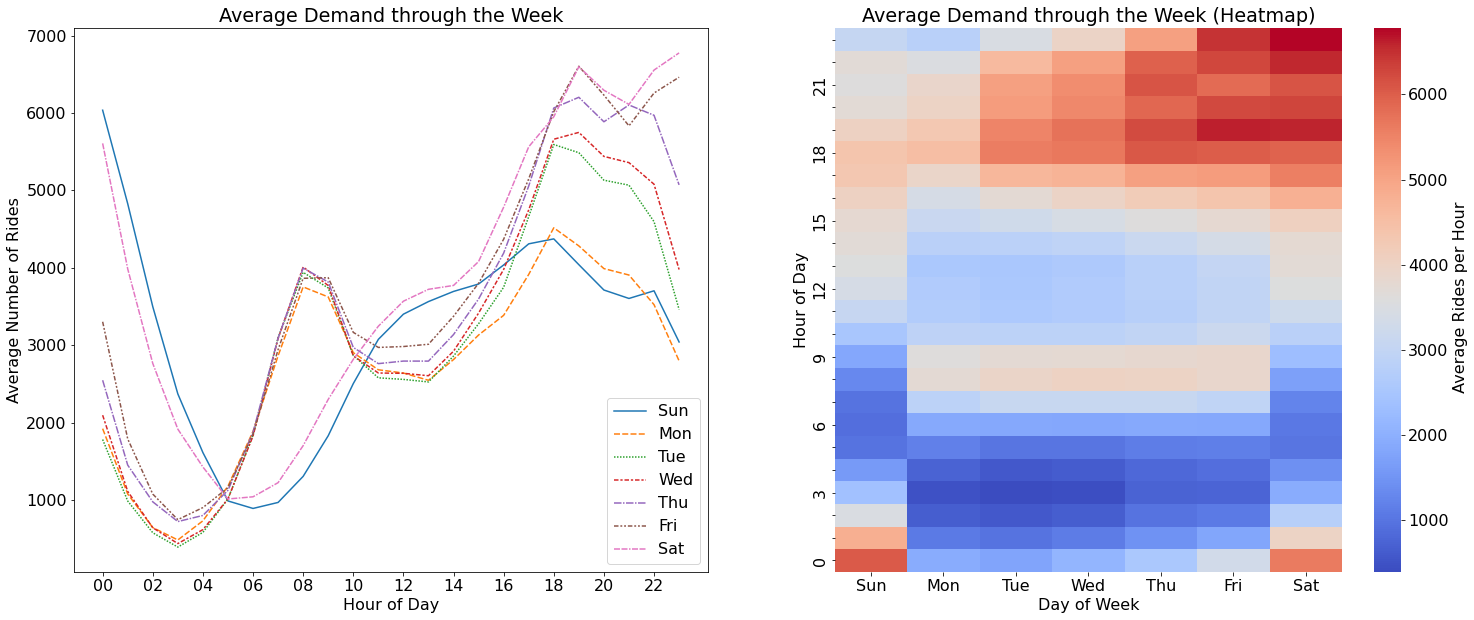

In [49]:
df_hour = df_hourly_rides[['datetime','datehour','day_of_week','count']]
df_hour['hour']=df_hour['datetime'].dt.strftime('%H')

hourly_rides_day_mean = df_hour.groupby(['hour','day_of_week']).mean().unstack()
hourly_rides_day_mean.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

fig, axes = plt.subplots(1,2, figsize=(25,10))

sns.lineplot(data=hourly_rides_day_mean, ax=axes[0])
axes[0].set_ylabel('Average Number of Rides')
axes[0].set_xlabel('Hour of Day')
axes[0].set_title('Average Demand through the Week')
axes[0].set_xticks(range(0,24,2));

sns.heatmap(hourly_rides_day_mean, ax=axes[1]
            , cmap='coolwarm', cbar_kws={'label':' Average Rides per Hour'})
axes[1].invert_yaxis()
axes[1].set_xlabel('Day of Week', fontsize=16);
axes[1].set_ylabel('Hour of Day', fontsize=16)
axes[1].set_title('Average Demand through the Week (Heatmap)')
axes[1].set_yticklabels(['0','','','3','',''
                         ,'6','','','9','',''
                         ,'12','','','15','',''
                         ,'18','','','21','','']);

figname = 'avgN_rides_per_Hour_heatmap'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

### Distribution of Demands per Day

In [50]:
df_rides_day = df_hourly_rides[['datetime','day_of_week','count']]
df_rides_day['day_of_week'] = df_rides_day['datetime'].dt.strftime('%a')
df_rides_day['date'] = df_rides_day['datetime'].dt.strftime('%Y-%m-%d')
daily_rides = df_rides_day.groupby(['date','day_of_week']).agg(sum).reset_index()
daily_rides.head()

date day_of_week  count
0  2015-01-01         Thu  58045
1  2015-01-02         Fri  40287
2  2015-01-03         Sat  59844
3  2015-01-04         Sun  41943
4  2015-01-05         Mon  43678

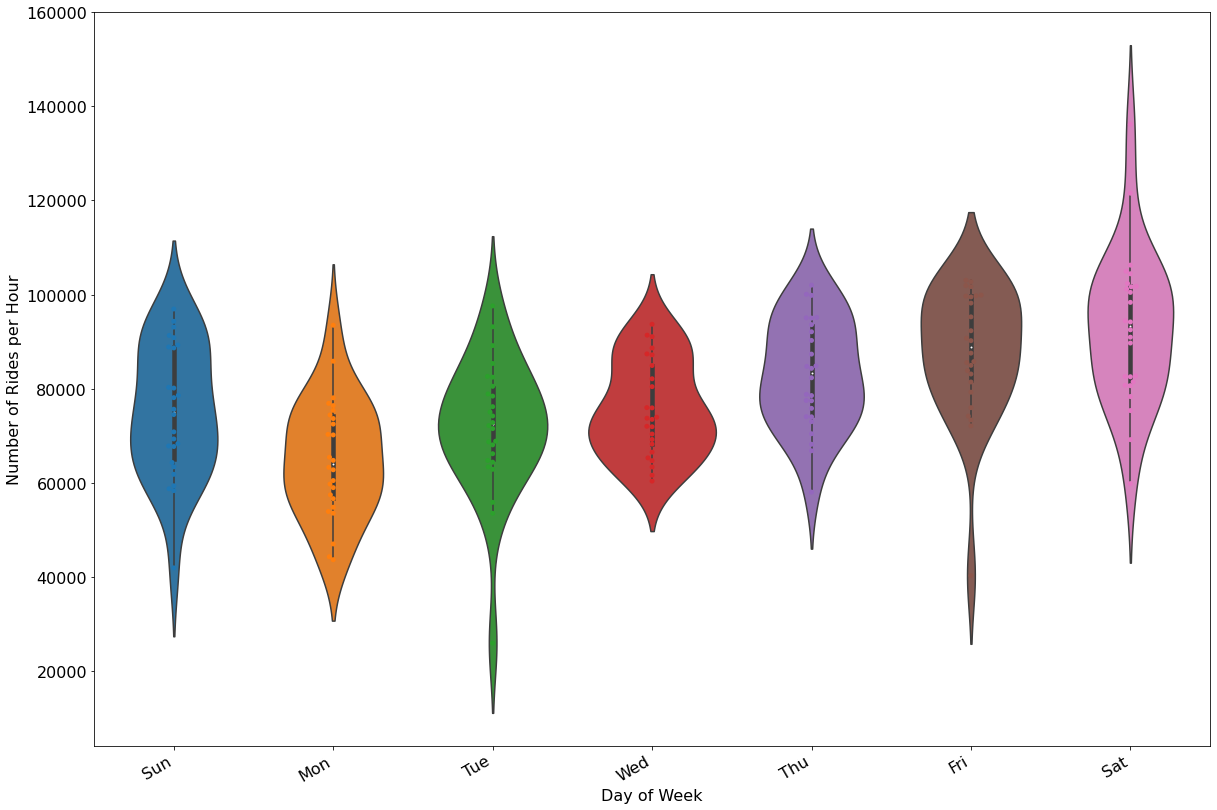

In [51]:
fig, ax = plt.subplots(figsize=(20,15))

order = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
# sns.boxplot(x='day_of_week', y='count', data=daily_rides, order=order)
sns.violinplot(x='day_of_week', y='count', data=daily_rides, order=order)
sns.swarmplot(x='day_of_week', y='count', data=daily_rides, order=order)
plt.gcf().autofmt_xdate()
ax.set_xlabel('Day of Week', fontsize=16);
ax.set_ylabel('Number of Rides per Hour', fontsize=16);
figname='Dist_N_rides_DayOfWeek'
plt.savefig(('images/'+figname+'.png'),  bbox_inches='tight')
# ax.legend()

### Average Demand through the week by Borough

In [52]:
df_hour_borough = df_hourly_rides_borough[['datetime','datehour','day_of_week','count','borough']]
df_hour_borough['hour'] = df_hour_borough['datetime'].dt.strftime('%H')

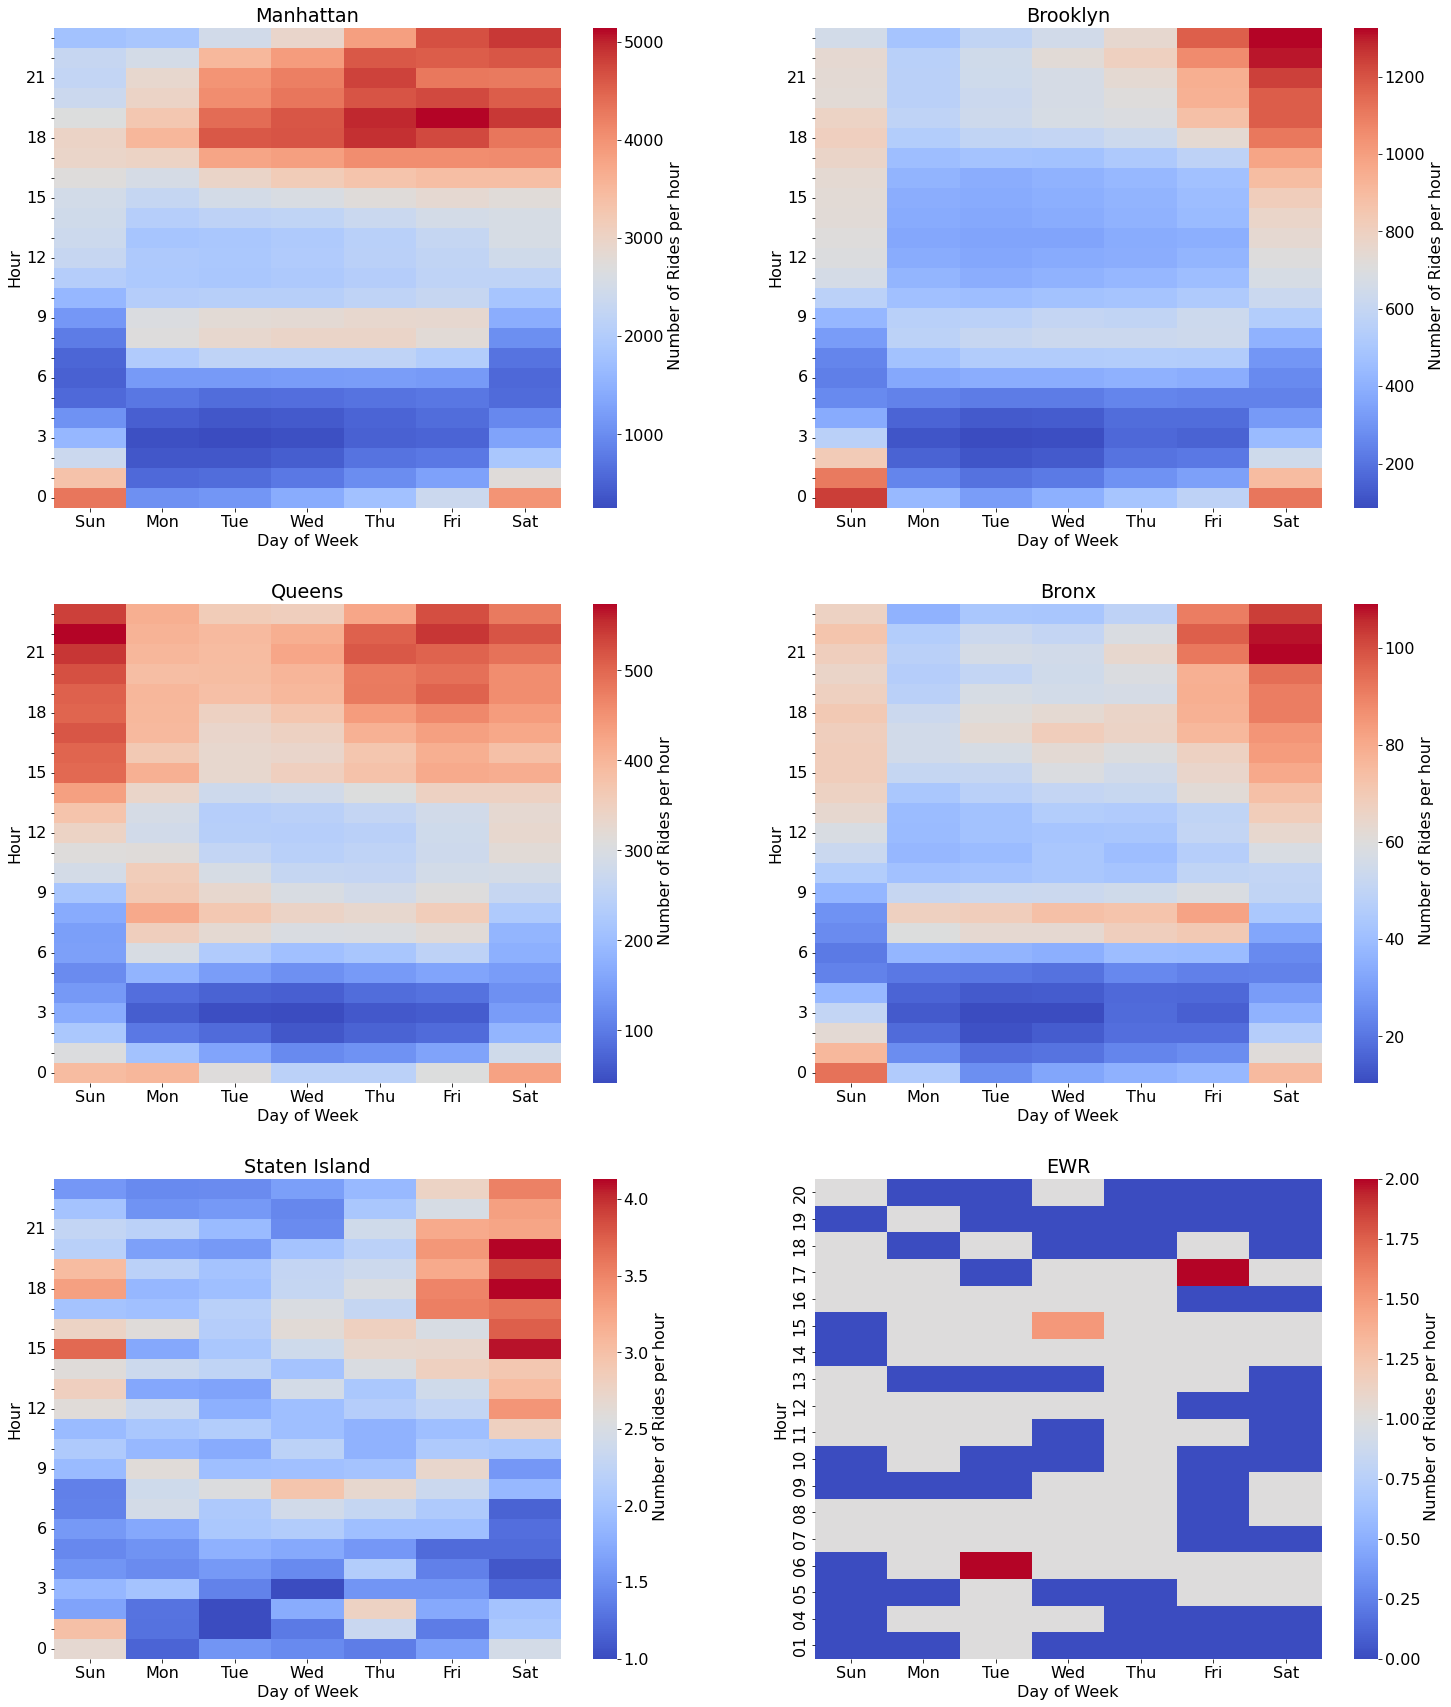

In [53]:
list_borough = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'EWR']
fig, axes = plt.subplots(3, 2, figsize=(25,30))

for borough, ax in zip(list_borough, axes.flat):
    rides_borough = (
        df_hour_borough.loc[df_hour_borough['borough']==borough]
        .groupby(['hour','day_of_week']).mean().unstack()
    )
    rides_borough.columns = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
    rides_borough=rides_borough.fillna(0)
    sns.heatmap(rides_borough 
                ,ax=ax,cmap='coolwarm',cbar_kws={'label':' Number of Rides per hour'})
    ax.invert_yaxis()
    ax.set_title(borough);
    ax.set_xlabel('Day of Week');
    ax.set_ylabel('Hour')
    if borough is not 'EWR':
        ax.set_yticklabels(['0','','','3','',''
                         ,'6','','','9','',''
                         ,'12','','','15','',''
                         ,'18','','','21','','']);
        
figname = 'avgN_rides_per_Hour_heatmap_by_Borough'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

### Correlation map

In [54]:
df_corr = df_hourly_rides_borough.copy()
df_corr = df_corr.drop(['datehour','datetime'], axis=1)

# sc = StandardScaler()
# df_corr['humidity'] = sc.fit_transform(df_corr[['humidity']])
# df_corr['temperature'] = sc.fit_transform(df_corr[['temperature']])
# df_corr['pressure'] = sc.fit_transform(df_corr[['pressure']])
# df_corr['wind_direction'] = sc.fit_transform(df_corr[['wind_direction']])
# df_corr['wind_speed'] = sc.fit_transform(df_corr[['wind_speed']])

df_corr = pd.get_dummies(df_corr)

df_corr.head()

count  humidity  pressure  temperature  wind_direction  wind_speed  \
0    144      59.0    1022.0         -5.1           249.0         2.0   
1   1371      59.0    1022.0         -5.1           249.0         2.0   
2   4567      59.0    1022.0         -5.1           249.0         2.0   
3    377      59.0    1022.0         -5.1           249.0         2.0   
4      3      59.0    1022.0         -5.1           249.0         2.0   

   borough_Bronx  borough_Brooklyn  borough_EWR  borough_Manhattan  ...  \
0              1                 0            0                  0  ...   
1              0                 1            0                  0  ...   
2              0                 0            0                  1  ...   
3              0                 0            0                  0  ...   
4              0                 0            0                  0  ...   

   weather_description_thunderstorm  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   weather_description_thunderstorm with light rain  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   weather_description_very heavy rain  day_of_week_0  day_of_week_1  \
0                                    0              0              0   
1                                    0              0              0   
2                                    0              0              0   
3                                    0              0              0   
4                                    0              0              0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  
0              0              0              1              0              0  
1              0              0              1              0              0  
2              0              0              1              0              0  
3              0              0              1              0              0  
4              0              0              1              0              0  

[5 rows x 39 columns]

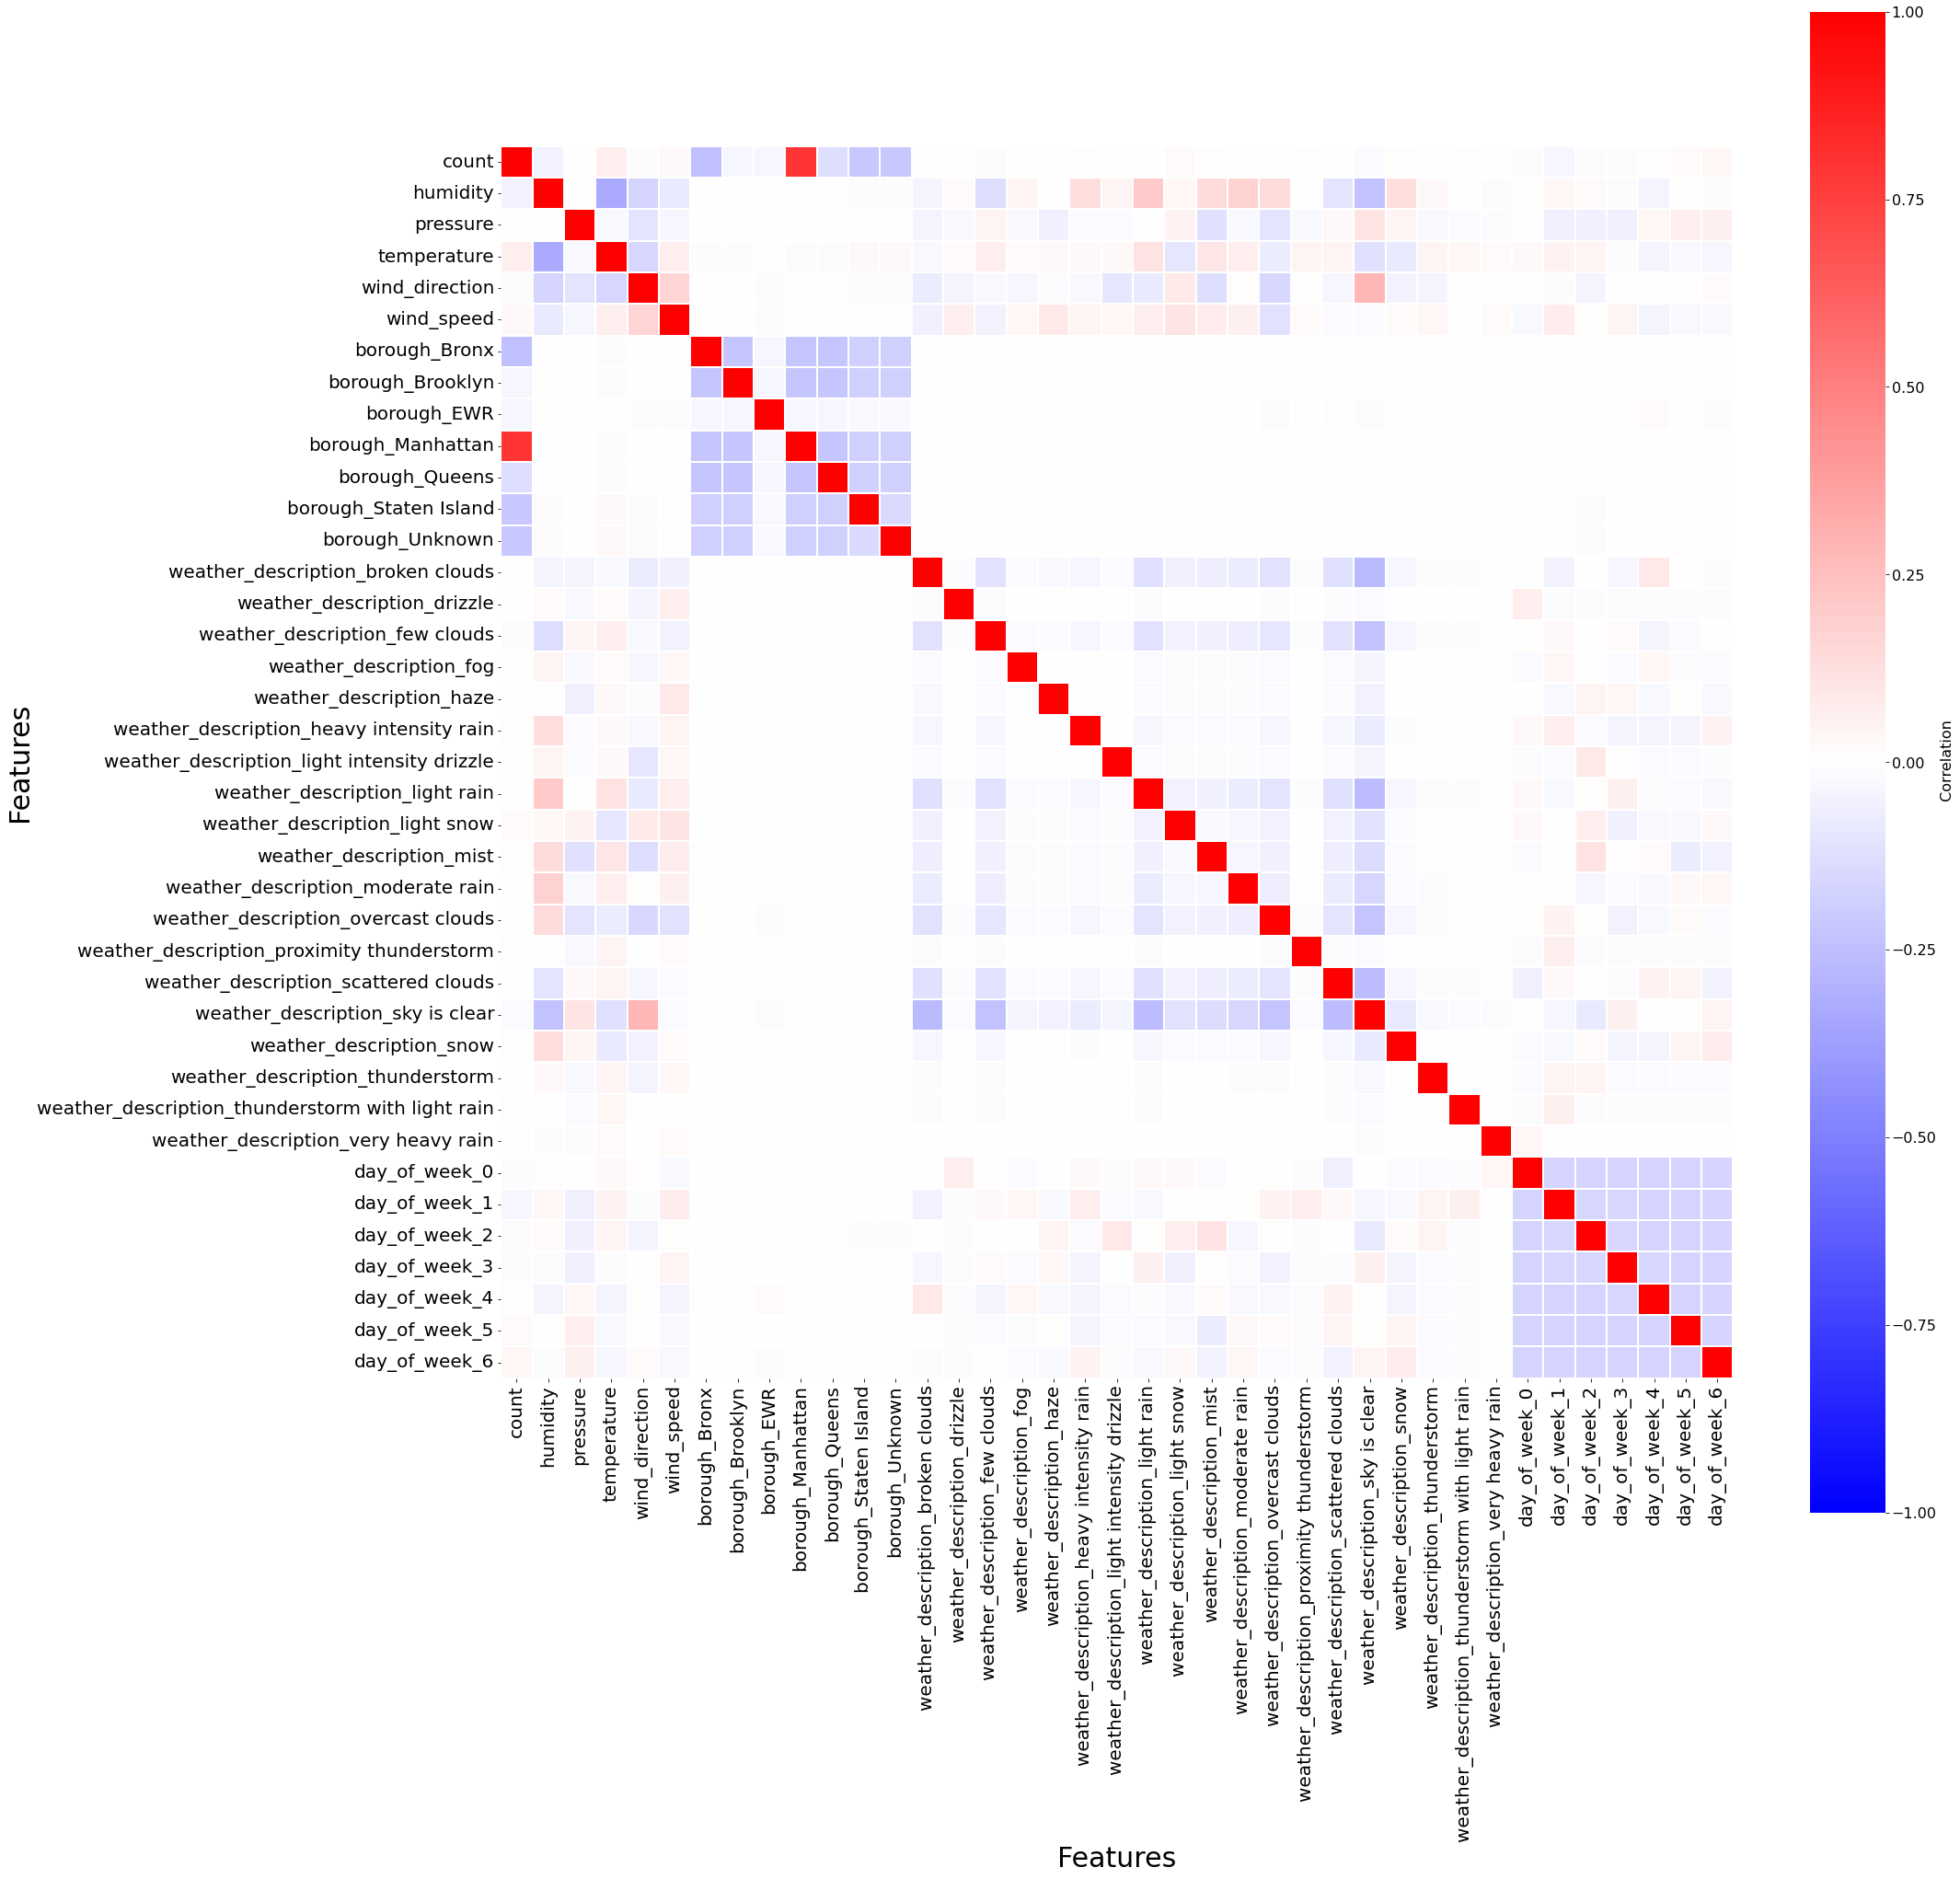

In [55]:
fig, ax = plt.subplots(figsize=(30,30))

sns.heatmap(df_corr.corr(),vmax=1, vmin=-1, cmap='bwr'
            , square=True, ax=ax, linewidths=0.1, center=0
            , cbar_kws={'label':' Correlation'})
ax.set_xlabel('Features', fontsize=30);
ax.set_ylabel('Features', fontsize=30);
ax.set_xticklabels(df_corr.columns,fontsize=20);
ax.set_yticklabels(df_corr.columns,fontsize=20);

figname = 'Correlation_map'
plt.savefig(('images/'+figname+'.png'), bbox_inches='tight')

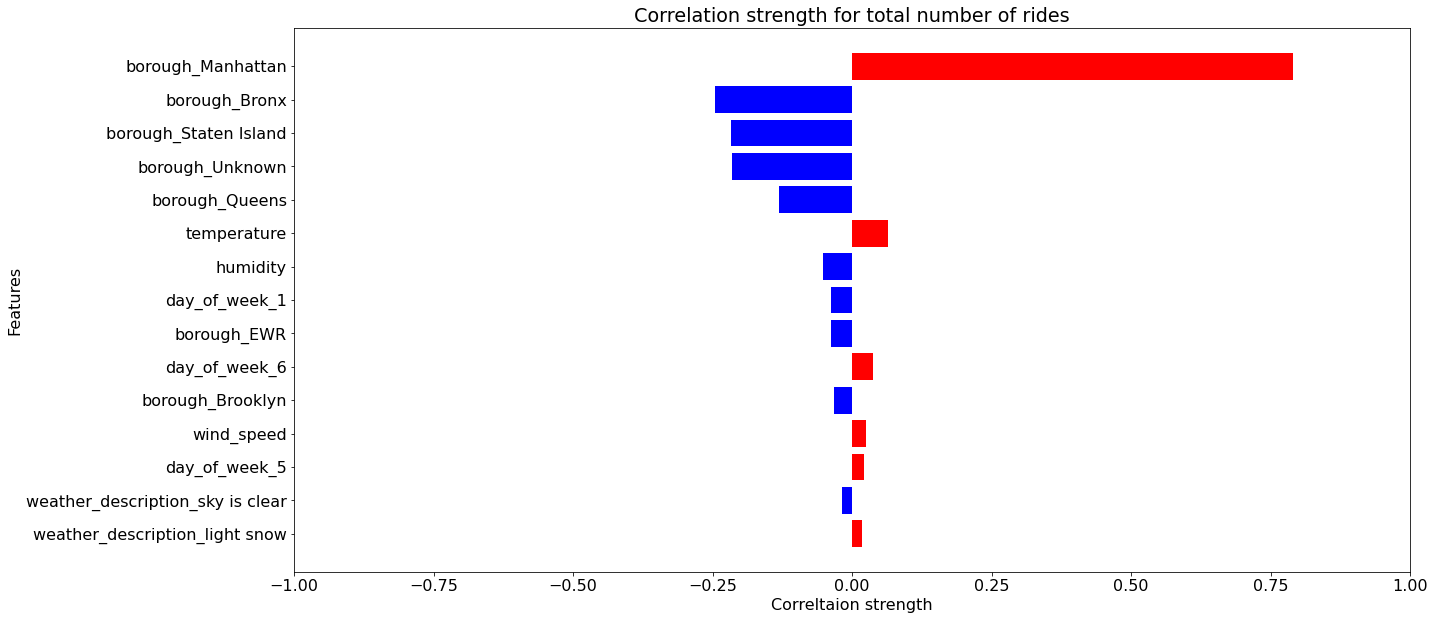

In [56]:
fig, ax = plt.subplots(figsize =(20,10))
corr_matt_sub = df_corr.corr().drop('count', axis=0)

corr_values = pd.DataFrame({'x':corr_matt_sub['count'][:].values, 'y':corr_matt_sub['count'][:].index})
corr_values['abs_x'] = np.abs(corr_values['x'])
corr_values = corr_values.sort_values(by='abs_x', ascending=False)
corr_values = corr_values.drop('abs_x', axis=1)


color_cor = []
for i in corr_values['x']:
    if i >= 0:
        color_cor.append('red')
    else:
        color_cor.append('blue')

plt.barh(corr_values['y'][:15], corr_values['x'][:15]
        , color = color_cor)

plt.xlim([-1, 1])
ax.set_xlabel('Correltaion strength');
ax.set_title("Correlation strength for total number of rides");
ax.set_ylabel('Features')
ax.invert_yaxis();
figname='CorrelationStrength_TotalRides'
plt.savefig(('images/'+figname+'.png'),  bbox_inches='tight')
plt.show()

In [57]:
# Correlation 
corr_matt_sub['count'][:]

humidity                                           -0.051953
pressure                                           -0.005725
temperature                                         0.065102
wind_direction                                     -0.010699
wind_speed                                          0.025177
borough_Bronx                                      -0.246076
borough_Brooklyn                                   -0.031664
borough_EWR                                        -0.037221
borough_Manhattan                                   0.789427
borough_Queens                                     -0.131436
borough_Staten Island                              -0.217345
borough_Unknown                                    -0.215487
weather_description_broken clouds                   0.002328
weather_description_drizzle                        -0.003478
weather_description_few clouds                     -0.008952
weather_description_fog                             0.001106
weather_description_haze

<a id="3.4"></a>
***
***
## Summary of EDA
***
<div class='alert-info'>

- It seems that **time variables (time, day of week)** have a much stronger effect on demand for the rides than **weather variables**.

</div>

<a id="4"></a>
***
***
# Preprocessing 
***
Based on the insights obtained from [EDA](#3) and [Visualisation](#4.3), Preprocess the data used in modelling.

<a id="4.1"></a>
***
***
## Feature Engineering
***

In [58]:
df_hourly_rides.head()

datehour  count            datetime  humidity  pressure  \
0 2015-01-01 00:00:00   6465 2015-01-01 00:00:00      59.0    1022.0   
1 2015-01-01 01:00:00   6001 2015-01-01 01:00:00      59.0    1022.0   
2 2015-01-01 02:00:00   7171 2015-01-01 02:00:00      58.0    1021.0   
3 2015-01-01 03:00:00   5874 2015-01-01 03:00:00      58.0    1021.0   
4 2015-01-01 04:00:00   3529 2015-01-01 04:00:00      58.0    1021.0   

   temperature weather_description  wind_direction  wind_speed day_of_week  
0       -5.100        sky is clear           249.0         2.0           4  
1       -5.100        sky is clear           249.0         2.0           4  
2       -5.964        sky is clear           246.0         2.0           4  
3       -5.964        sky is clear           246.0         2.0           4  
4       -5.964        sky is clear           246.0         2.0           4

In [59]:
df_hour_borough

datetime            datehour day_of_week  count  \
0     2015-01-01 00:00:00 2015-01-01 00:00:00           4    144   
1     2015-01-01 00:00:00 2015-01-01 00:00:00           4   1371   
2     2015-01-01 00:00:00 2015-01-01 00:00:00           4   4567   
3     2015-01-01 00:00:00 2015-01-01 00:00:00           4    377   
4     2015-01-01 00:00:00 2015-01-01 00:00:00           4      3   
...                   ...                 ...         ...    ...   
23490 2015-06-30 23:00:00 2015-06-30 23:00:00           2    915   
23491 2015-06-30 23:00:00 2015-06-30 23:00:00           2   3166   
23492 2015-06-30 23:00:00 2015-06-30 23:00:00           2    576   
23493 2015-06-30 23:00:00 2015-06-30 23:00:00           2      1   
23494 2015-06-30 23:00:00 2015-06-30 23:00:00           2      3   

             borough hour  
0              Bronx   00  
1           Brooklyn   00  
2          Manhattan   00  
3             Queens   00  
4      Staten Island   00  
...              ...  ...  
23490       Brooklyn   23  
23491      Manhattan   23  
23492         Queens   23  
23493  Staten Island   23  
23494        Unknown   23  

[23495 rows x 6 columns]

### Data preparation for modelling
---

In [60]:
df_model_rides = df_hourly_rides.copy()
# df_model_rides['day_of_week'] = df_model_rides['datetime'].dt.strftime('%a') 
df_model_rides = df_model_rides.drop(['datehour','day_of_week'], axis=1)
df_model_rides['time_block_num'] = df_model_rides.index+1

# Standardize the variables
sc = StandardScaler()
df_model_rides['humidity'] = sc.fit_transform(df_model_rides[['humidity']])
df_model_rides['temperature'] = sc.fit_transform(df_model_rides[['temperature']])
df_model_rides['pressure'] = sc.fit_transform(df_model_rides[['pressure']])
df_model_rides['wind_direction'] = sc.fit_transform(df_model_rides[['wind_direction']])
df_model_rides['wind_speed'] = sc.fit_transform(df_model_rides[['wind_speed']])
df_model_rides['day_of_week'] = df_model_rides['datetime'].dt.strftime('%a')
# Get one-hot label data for weather description 
df_model_rides = pd.get_dummies(df_model_rides)


borough_list_model = ['Manhattan', 'Brooklyn', 'Queens']
df_borough_model = df_hour_borough[['datetime', 'count', 'borough']]
for borough in borough_list_model:
    df_borough = df_borough_model.loc[df_borough_model['borough']==borough]
    df_borough=df_borough.drop(['borough'], axis=1)
    df_borough.columns = ['datetime']+['rides_'+borough]
    df_model_rides = pd.merge(df_model_rides, df_borough, on='datetime', how='left')
    
# log transformation
# df_model_rides['count'] = np.log1p(df_model_rides['count'])
# df_model_rides['rides_Brooklyn'] = np.log1p(df_model_rides['rides_Brooklyn'])
# df_model_rides['rides_Manhattan'] = np.log1p(df_model_rides['rides_Manhattan'])
# df_model_rides['rides_Queens'] =np.log1p(df_model_rides['rides_Queens'])

df_model_rides.columns

Index(['count', 'datetime', 'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'time_block_num',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_description_few clouds', 'weather_description_fog',
       'weather_description_haze', 'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light rain', 'weather_description_light snow',
       'weather_description_mist', 'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity thunderstorm',
       'weather_description_scattered clouds',
       'weather_description_sky is clear', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with light rain',
       'weather_description_very heavy rain', 'day_of_week_Fri',
       'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
     

### Create Lag Features 
---
In time series data, at any point in time, the model needs information about the past. Here, to pass the past (most recent) information, the lag feature is created.

In [61]:
lag_variables = [
       'count'
       , 'rides_Manhattan', 'rides_Brooklyn', 'rides_Queens'
       ,'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze',
       'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light rain', 'weather_description_light snow',
       'weather_description_mist', 'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity thunderstorm',
       'weather_description_scattered clouds',
       'weather_description_sky is clear', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with light rain',
       'weather_description_very heavy rain',
       'day_of_week_Fri',
       'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun',
       'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed']

# lags (1hr, 2hr, 3hr, 6hr, 12hr, 1day, 1week)
lags = [1, 2, 3, 6, 12, 24, 168]

In [62]:
#Create Lag Features
df_model = df_model_rides.copy()

for lag in lags:
    
    df_lag = df_model.copy()
    df_lag.time_block_num+=lag
    # subset only the lag variable required
    df_lag = df_lag[['time_block_num']+lag_variables]
    df_lag.columns = ['time_block_num']+[lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    
    df_model = pd.merge(df_model, df_lag, on=['time_block_num'], how='left')
    
df_model = df_model.drop(range(0,168)).reset_index()
df_model = df_model.drop(['index'], axis=1)

df_model

count            datetime  humidity  pressure  temperature  \
0      1654 2015-01-08 00:00:00 -1.604268 -0.840260    -1.399546   
1       838 2015-01-08 01:00:00 -1.604268 -0.649606    -1.529463   
2       482 2015-01-08 02:00:00 -1.491482 -0.554279    -1.580366   
3       325 2015-01-08 03:00:00 -1.378695 -0.554279    -1.614302   
4       412 2015-01-08 04:00:00 -1.322302 -0.554279    -1.639753   
...     ...                 ...       ...       ...          ...   
4161   5807 2015-06-30 19:00:00 -1.209515 -0.935588     1.726637   
4162   5392 2015-06-30 20:00:00 -1.040335 -0.935588     1.668947   
4163   5955 2015-06-30 21:00:00 -1.209515 -0.935588     1.632467   
4164   5749 2015-06-30 22:00:00 -0.645582 -1.030915     1.551022   
4165   4731 2015-06-30 23:00:00 -0.194436 -1.030915     1.486544   

      wind_direction  wind_speed  time_block_num  \
0          -2.154214   -0.333756             169   
1          -2.238825   -0.333756             170   
2           1.462924    0.381625             171   
3           1.039867    1.812387             172   
4           1.462924   -0.333756             173   
...              ...         ...             ...   
4161       -0.705243    1.812387            4330   
4162       -0.387950    1.097006            4331   
4163       -0.493715    0.381625            4332   
4164       -0.705243    1.812387            4333   
4165       -0.705243    1.812387            4334   

      weather_description_broken clouds  weather_description_drizzle  ...  \
0                                     0                            0  ...   
1                                     0                            0  ...   
2                                     0                            0  ...   
3                                     0                            0  ...   
4                                     0                            0  ...   
...                                 ...                          ...  ...   
4161                                  1                            0  ...   
4162                                  1                            0  ...   
4163                                  0                            0  ...   
4164                                  0                            0  ...   
4165                                  0                            0  ...   

      weather_description_thunderstorm_lag_168  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
4161                                       0.0   
4162                                       0.0   
4163                                       0.0   
4164                                       0.0   
4165                                       0.0   

      weather_description_thunderstorm with light rain_lag_168  \
0                                                   0.0          
1                                                   0.0          
2                                                   0.0          
3                                                   0.0          
4                                                   0.0          
...                                                 ...          
4161                                                0.0          
4162                                                0.0          
4163                                                0.0          
4164                                                0.0          
4165                                                0.0          

      weather_description_very heavy rain_lag_168  day_of_week_Fri_lag_168  \
0                                             0.0                      0.0   
1                                             0.0                      0.0   
2          

<a id="5"></a>
***
***
# Model Deployment
***


In [63]:
# Split the data into test data and Validation data

# Length of test data (days)
test_length = 30

df_train = df_model[df_model['time_block_num'] <= (df_model['time_block_num'].max()-24*test_length)]
df_test = df_model[df_model['time_block_num'] > (df_model['time_block_num'].max()-24*test_length)]

print('Time period of Train data')
print('Min time: %s' % df_train['datetime'].min())
print('Min time: %s' % df_train['datetime'].max())
print('\nTime period of Test data')
print('Min time: %s' % df_test['datetime'].min())
print('Min time: %s' % df_test['datetime'].max())

Time period of Train data
Min time: 2015-01-08 00:00:00
Min time: 2015-05-31 23:00:00

Time period of Test data
Min time: 2015-06-01 00:00:00
Min time: 2015-06-30 23:00:00


In [64]:
# Keep the datetime info with 'time_block_num'
time_block = df_model[['datetime', 'time_block_num']]
df_model = df_model.drop('datetime', axis=1)
df_train = df_train.drop('datetime', axis=1)
df_test = df_test.drop('datetime', axis=1)

In [65]:
def prediction_XGBoost(df_train, df_test, model, target_list
                       , feature_select=False, log_transform=False, include_borough=False):
    
    def _mape(true, pred): 
        true, pred = np.array(true), np.array(pred)
        return np.mean(np.abs((true - pred) / true)) * 100
    
    results = {}
    for target in target_list:
#         print(model)
        print('Forecasting:'+target)
        new_df_train = df_train.copy()
        new_df_test = df_test.copy()
        
        # Define Y_train and Y_test (Target label)
        Y_train = new_df_train[target]
        Y_test = new_df_test[target]
        
        
        drop_list = target_list.copy() # list of dropped variables

        ##----- When rides variables for majour borough are not included ------------------##
        if include_borough:
            del_borough_list = target_list.copy()
            del_borough_list.remove(target)
            for del_borough in del_borough_list:
                all_columns_df_model = list(df_model.columns) # all columns of df_train
                drop_borough_col = df_train.columns.str.contains(del_borough+'_') #boolean
                drop_borough_list = list(compress(col_name_df_model, drop_borough_col))
                # Add dropped columns on the drop_list
                drop_list = drop_list + drop_borough_list
        ##---------------------------------------------------------------------------------##
        
        # Define X_train and X_test (Features)
        X_train = new_df_train.drop(drop_list, axis=1)
        X_test = new_df_test.drop(drop_list, axis=1)
        
        
        
        # Feature selection----------------------------------------------------------------##
        if feature_select:
            feature_selector =BorutaPy(model
                                   ,n_estimators='auto' 
                                   ,verbose=0 # 0: no output,1: displays iteration number,2: which features have been selected already
                                   ,alpha=0.1
                                   ,max_iter=100
                                   ,random_state=42
                                  )
            feature_selector.fit(X_train.values, Y_train.values)
            # Select only selected feature
            X_train = X_train.iloc[:,feature_selector.support_]
            X_test = X_test.iloc[:,feature_selector.support_]
        
        # ---------------------------------------------------------------------------------##
        
        
        # Fitting
        model.fit(
            X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_test, Y_test)], 
            verbose=0
#             early_stopping_rounds = 10
        )
        
        # Prediction
        Y_predict = model.predict(X_test)
        if log_transform:
            # Accuracy (RMSE)
            mse = mean_squared_error(Y_test,Y_predict)
            rmse = np.sqrt(mse)
            print('RMLSE: ' + str(np.round(rmse, 2)))

            # Accuracy (MAPE)
            mape = _mape(np.expm1(Y_test), np.expm1(Y_predict))
            print('MAPE: ' + str(np.round(mape, 2)) +'%')
        
            # Results
            results[target] = {'feature_importances': model.feature_importances_
                               ,'mape': mape
                               ,'rmse': rmse
                               ,'X_train': X_train
                               ,'X_test': X_test
                               ,'Y_train': np.expm1(Y_train)
                               ,'Y_test': np.expm1(Y_test)
                               ,'Y_predict': np.expm1(Y_predict)
                          }
            
            
            
            ## Plot feature importances
            fig, ax = plt.subplot()
            
            
            
            
        else:
            
            # Accuracy (RMSE)
            mse = mean_squared_error(Y_test, Y_predict)
            rmse = np.sqrt(mse)
            print('RMSE: ' + str(np.round(rmse, 2)))

            # Accuracy (MAPE)
            mape = _mape(Y_test, Y_predict)
            print('MAPE: ' + str(np.round(mape, 2)) +'%')
            
            # Results
            results[target] = {'feature_importances': model.feature_importances_
                               ,'mape': mape
                               ,'rmse': rmse
                               ,'X_train': X_train
                               ,'X_test': X_test
                               ,'Y_train': Y_train
                               ,'Y_test': Y_test
                               ,'Y_predict': Y_predict
                              }
            
    return results

In [66]:
target_list = ['count', 'rides_Manhattan', 'rides_Brooklyn', 'rides_Queens']

<a id="5.1"></a>
***
***
## Baseline Model 
***

In [67]:
# Basic Model (Without parameter tuning)
model = XGBRegressor(seed=42)

In [68]:
results1 = prediction_XGBoost(df_train, df_test, model, target_list)

Forecasting:count
RMSE: 472.78
MAPE: 9.66%
Forecasting:rides_Manhattan
RMSE: 370.86
MAPE: 9.74%
Forecasting:rides_Brooklyn
RMSE: 81.14
MAPE: 10.08%
Forecasting:rides_Queens
RMSE: 59.12
MAPE: 12.72%


<a id="5.2"></a>
***
***
## Model Tuning
***

<a id="5.2.1"></a>
***
### Hyper-parameter Tuning
***

In [69]:
model = XGBRegressor(
    max_depth=20,
    n_estimators=1000,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
    seed=42)

In [70]:
results2 = prediction_XGBoost(df_train, df_test, model, target_list)

Forecasting:count
RMSE: 484.79
MAPE: 8.31%
Forecasting:rides_Manhattan
RMSE: 399.77
MAPE: 9.92%
Forecasting:rides_Brooklyn
RMSE: 83.85
MAPE: 9.35%
Forecasting:rides_Queens
RMSE: 63.06
MAPE: 13.48%


<a id="5.2.3"></a>
***
### Feature Selection by Boruta 
***

In [71]:
model = XGBRegressor(
    max_depth=20,
    n_estimators=1000,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
    seed=42)

In [72]:
results3 = prediction_XGBoost(df_train, df_test, model, target_list, feature_select=True)

Forecasting:count
RMSE: 484.88
MAPE: 8.49%
Forecasting:rides_Manhattan
RMSE: 364.0
MAPE: 9.06%
Forecasting:rides_Brooklyn
RMSE: 77.95
MAPE: 8.72%
Forecasting:rides_Queens
RMSE: 60.66
MAPE: 12.96%


<a id="6"></a>
***
***
# Deploy 
***

In [73]:
def plot_feat_imp(results, target_list, num_feat=10, label_str=''):
    df_res = results.copy()
    for target in target_list:
        print(target)
        #Extract data
        feat_imp_target = results[target]['feature_importances']
        X_train_target = results[target]['X_train']
        
        df_feat_imp = pd.DataFrame({'col': X_train_target.columns,'imp':feat_imp_target})
        df_feat_imp = df_feat_imp.sort_values(by='imp',ascending=False)
        if df_feat_imp.shape[0] > num_feat:
            df_feat_imp = df_feat_imp.iloc[:10]
            
        # Plot
        fig, ax = plt.subplots(figsize=(20,5))
        
        bar = ax.barh(df_feat_imp.col, df_feat_imp.imp, 0.6
                     , color=mcolors.TABLEAU_COLORS)
        ax.set_ylabel('Feature', fontsize=16);
        ax.set_xlabel('Feature Importances');
        ax.set_title('Feature Importances - '+target+label_str);
        ax.bar_label(bar, fmt='%.02f');
        
        ax.invert_yaxis();
        
        figname='Feature Importances - '+target+label_str
        plt.savefig(('images/'+figname+'.png'),  bbox_inches='tight')
        fig.tight_layout() 
        plt.show()
        
        

In [74]:
def plot_feat_imp_multi(results, target_list, num_feat=10, label_str=''):
    df_res = results.copy()
    fig, axes = plt.subplots(len(target_list), 1, figsize=(20,8*len(target_list)))
    for target, ax in zip(target_list, axes):
        print(target)
        #Extract data
        feat_imp_target = results[target]['feature_importances']
        X_train_target = results[target]['X_train']
        
        df_feat_imp = pd.DataFrame({'col': X_train_target.columns,'imp':feat_imp_target})
        df_feat_imp = df_feat_imp.sort_values(by='imp',ascending=False)
        if df_feat_imp.shape[0] > num_feat:
            df_feat_imp = df_feat_imp.iloc[:10]
            
        # Plot
        
        
        bar = ax.barh(df_feat_imp.col, df_feat_imp.imp, 0.6
                     , color=mcolors.TABLEAU_COLORS)
        ax.set_ylabel('Feature', fontsize=16);
        ax.set_xlabel('Feature Importances');
        ax.set_title('Feature Importances - '+target+label_str);
        ax.bar_label(bar, fmt='%.02f');
        
        ax.invert_yaxis();
        
    figname='Feature Importances - multi'+label_str
    plt.savefig(('images/'+figname+'.png'),  bbox_inches='tight')
    plt.show()

<a id="6.1"></a>
***
***
## Feature Importance
***

### Base Model

count
rides_Manhattan
rides_Brooklyn
rides_Queens


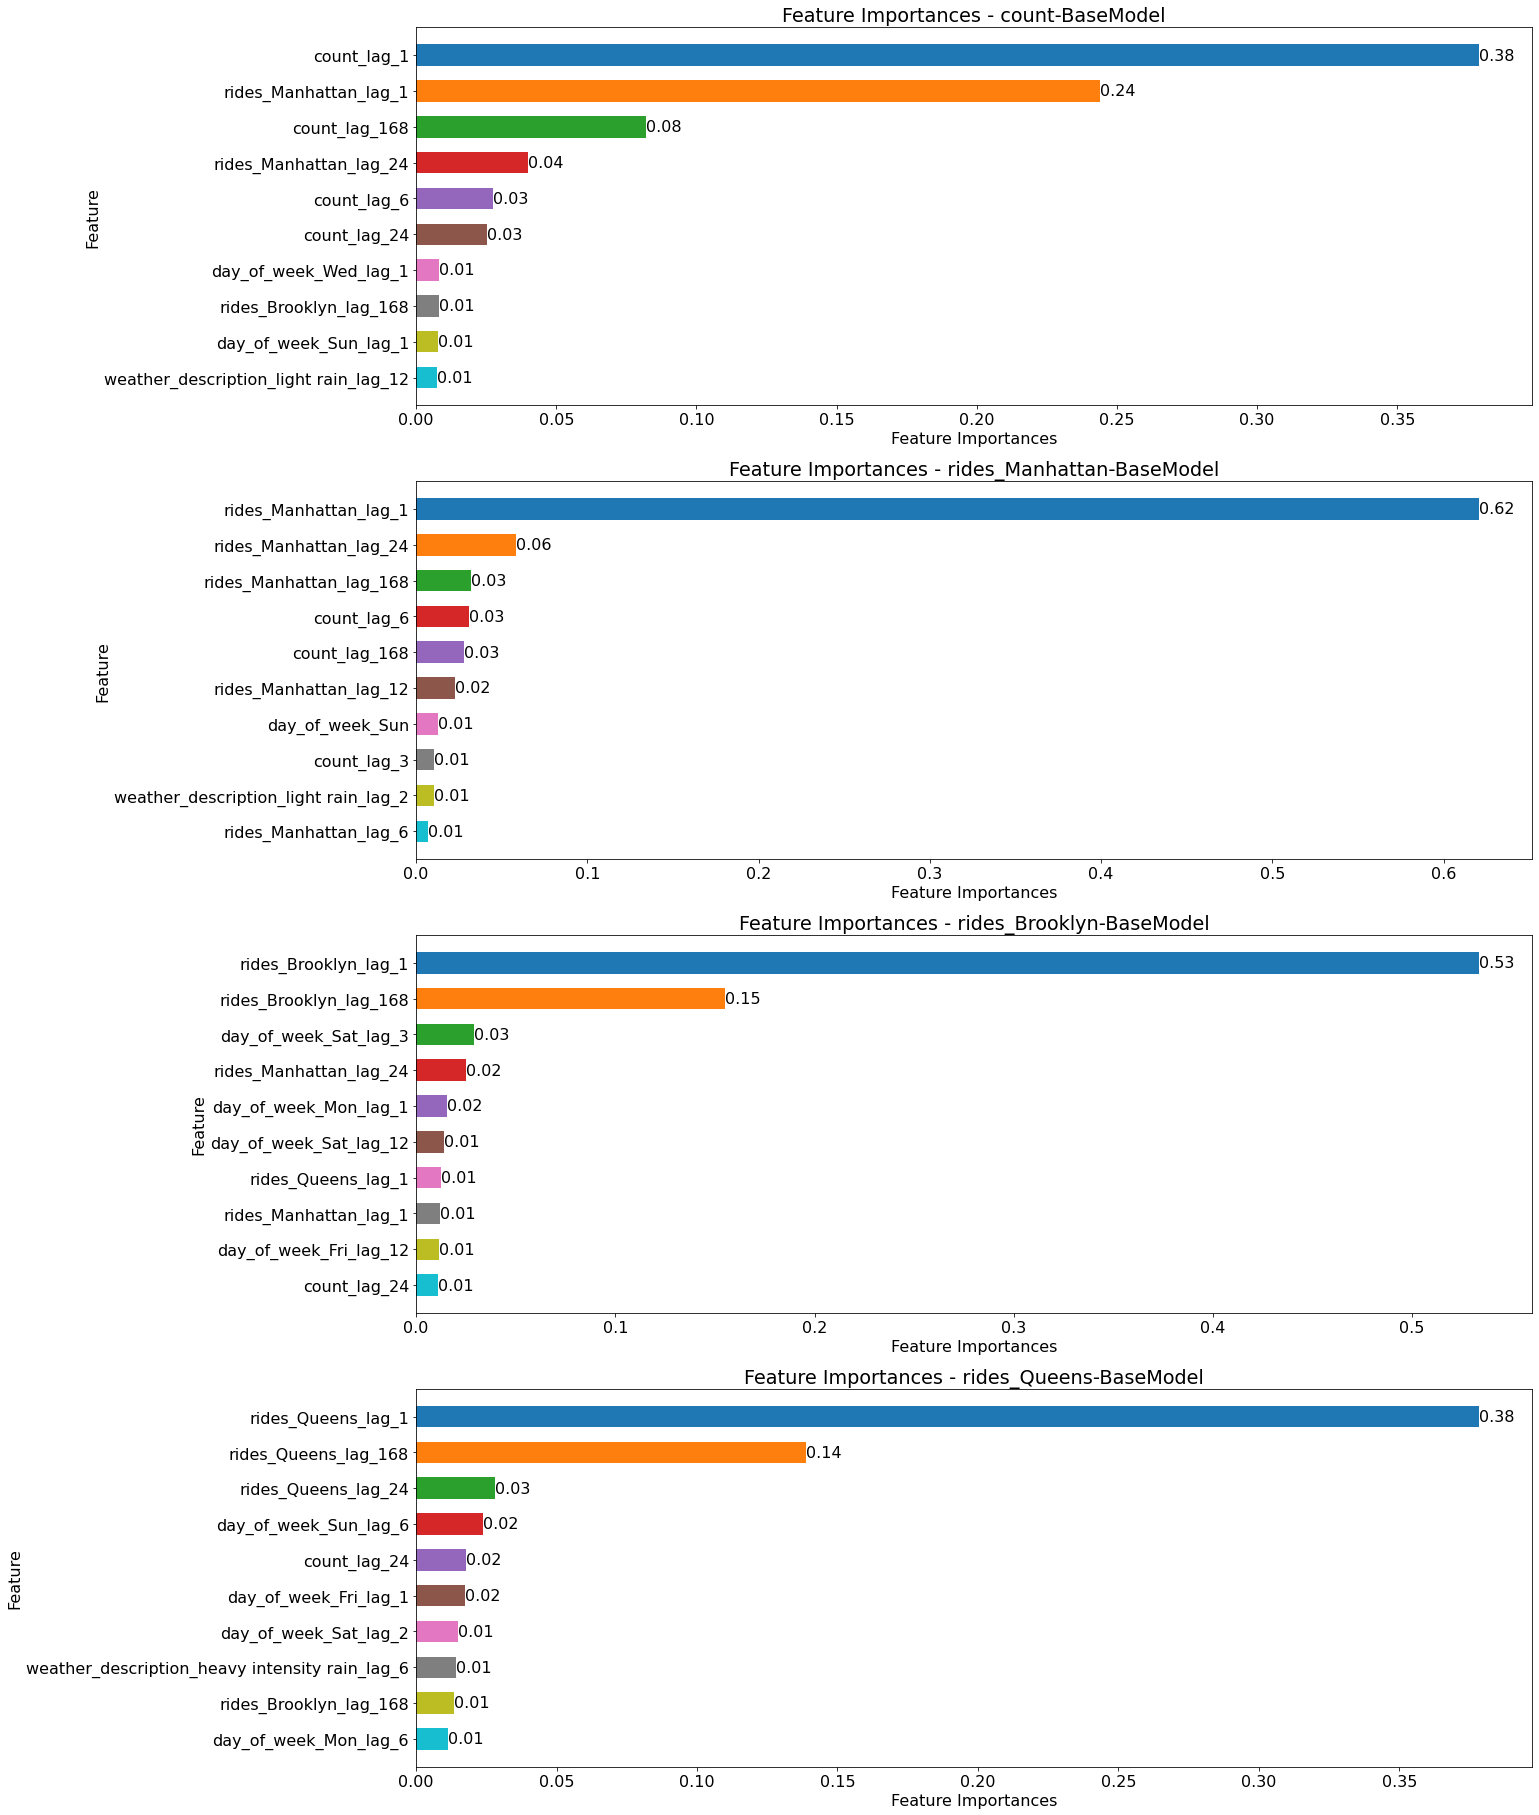

In [75]:
#Base Model
plot_feat_imp_multi(results1, target_list, label_str='-BaseModel')

### Tuned Model1 

count
rides_Manhattan
rides_Brooklyn
rides_Queens


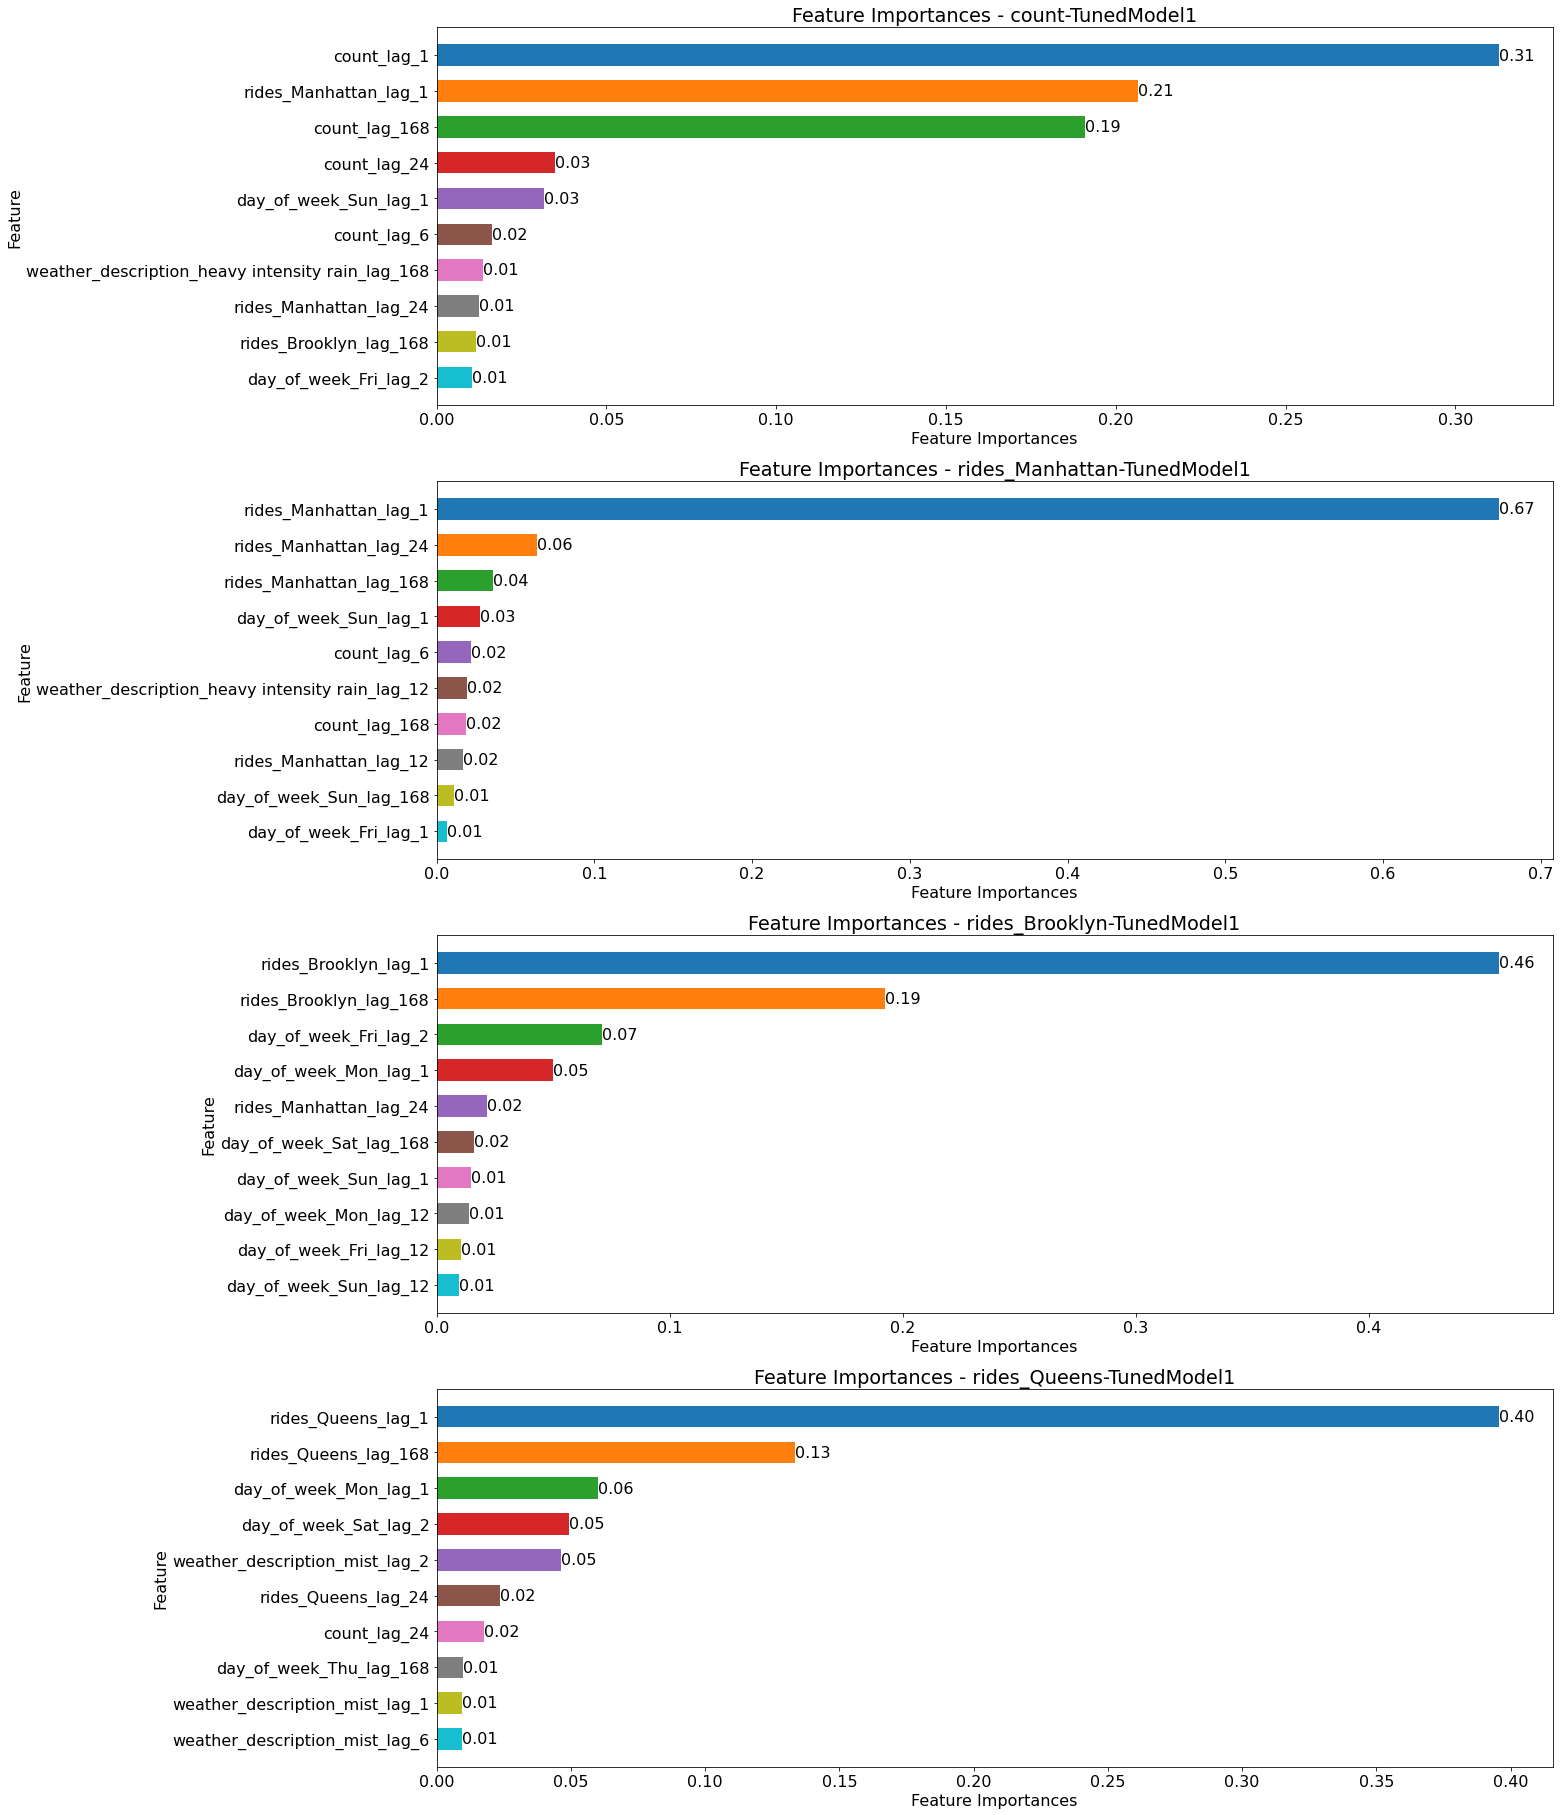

In [76]:
plot_feat_imp_multi(results2, target_list, label_str='-TunedModel1')

### Tuned Model2 

count
rides_Manhattan
rides_Brooklyn
rides_Queens


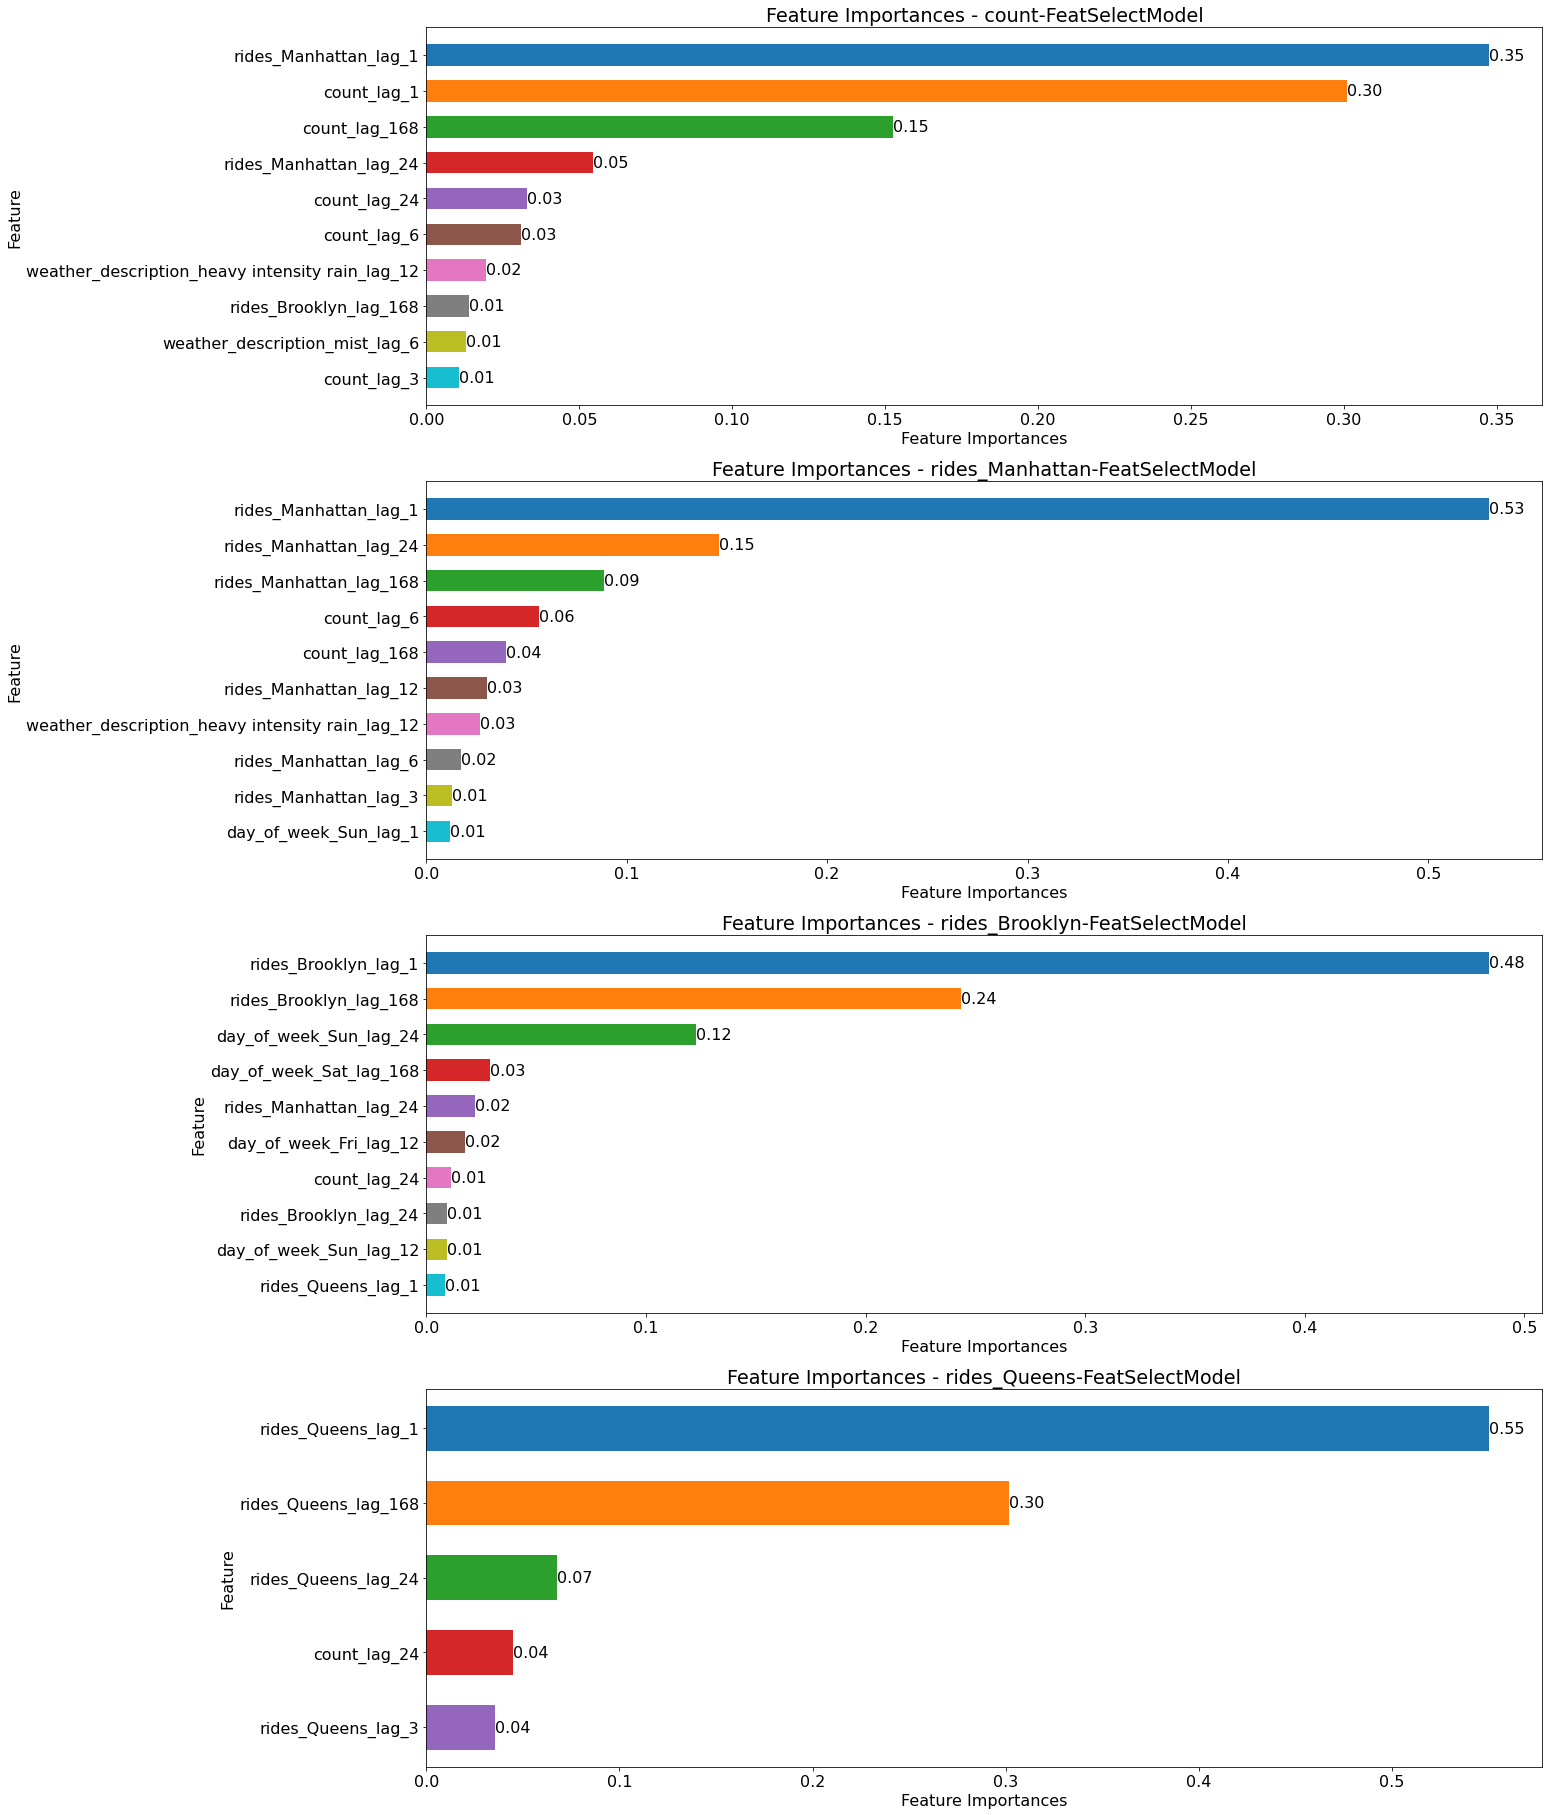

In [77]:
plot_feat_imp_multi(results3, target_list, label_str='-FeatSelectModel')

<a id="6.2"></a>
***
***
## Predicted vs True Data 
***

In [78]:
def plot_true_pred(results, target_list, time_block, label_str=''):
    
    
    for target in target_list:
        df_res = results.copy()
        print(target)
        #Extract data
        df_plot = df_res[target]['Y_test']
        df_plot = pd.merge(df_plot, time_block, left_index=True, right_index=True)
        df_plot = df_plot.drop('time_block_num', axis=1)
        
        df_plot['predict'] = df_res[target]['Y_predict']
        # Plot
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = df_plot['datetime'], y = df_plot[target],
                    mode='lines', 
                    name='True',
                    line=dict(color='blue')
                                ))
        fig.add_trace(go.Scatter(x = df_plot['datetime'], y = df_plot['predict'],
                    mode='lines',
                    name='Predict',
                    line=dict(color='red')
                                ))
        fig.update_layout(
            autosize=False
            , width=1600
            , height=500
            , yaxis=dict(title_text="Number of Rides"
                        ,titlefont=dict(size=18)
                        )
            , xaxis=dict(title_text="Date/Time"
                        ,titlefont=dict(size=18)
                        )
        )
        fig.update_yaxes(automargin=True, tickfont=dict(size=14)
                        , showline=True, linewidth=1, linecolor='black', mirror=True
                        , showgrid=True, gridwidth=1, gridcolor='#D0D0D0'
                        )
        fig.update_xaxes(automargin=True, tickfont=dict(size=14)
                        , showline=True, linewidth=1, linecolor='black', mirror=True
                        , showgrid=True, gridwidth=1, gridcolor='#D0D0D0'
                        )
        fig.layout.plot_bgcolor = '#fff'
        fig.layout.paper_bgcolor = '#fff'
        fig.show()
        
        

### Base Model

count


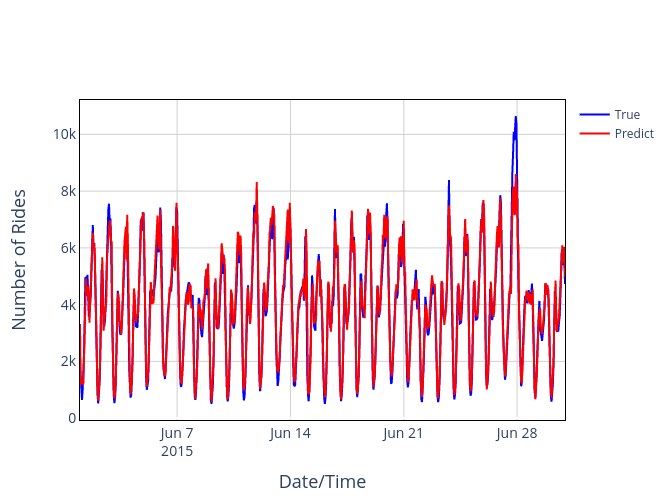

rides_Manhattan


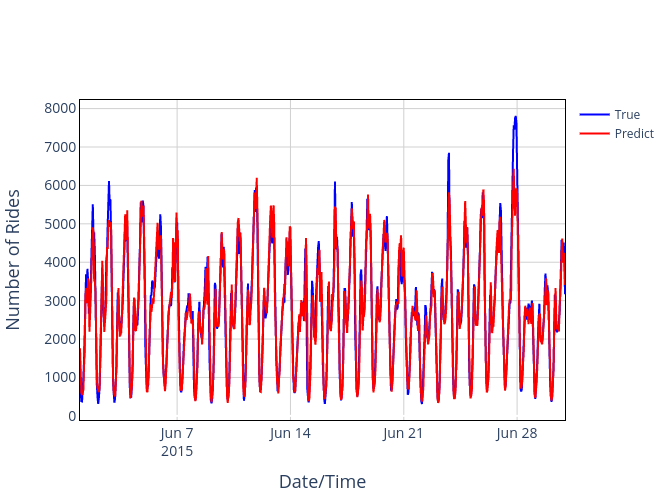

rides_Brooklyn


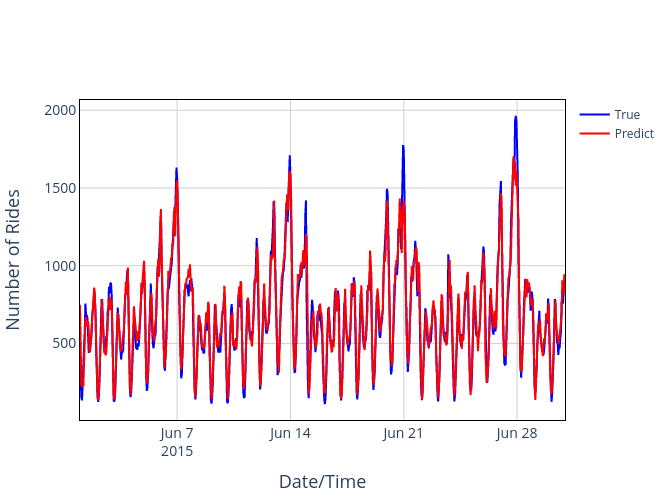

rides_Queens


In [79]:
# Base Model
plot_true_pred(results1, target_list, time_block)

### Tuned Model 1 

In [ ]:
# Tuned Model1
plot_true_pred(results2, target_list, time_block)

count


rides_Manhattan


rides_Brooklyn


rides_Queens


### Tuned Model 2

In [ ]:
# Tuned Model2
plot_true_pred(results3, target_list, time_block)